In [1]:
import os, glob, random

# point here to N_TXT folder
DATA_DIR = "SEMG_DB1 2/N_TXT"

# --- quick check of files ---
def list_txt_recursive(dd):
    return sorted(glob.glob(os.path.join(dd, "**", "*.txt"), recursive=True))

def try_parse_len(path):
    try:
        df = read_emg_txt(path)   # uses the robust loader from above
        return len(df)
    except Exception:
        return 0

all_txt = list_txt_recursive(DATA_DIR)
print(f"Found .txt files (recursive): {len(all_txt)}")

parsed = [(p, try_parse_len(p)) for p in all_txt]
valid = [(os.path.basename(p), n) for p, n in parsed if n > 0]

print(f"Parsable files: {len(valid)}")

# show top 5 largest by rows
valid_sorted = sorted(valid, key=lambda x: x[1], reverse=True)
print("\nTop 5 largest recordings:")
for f, n in valid_sorted[:5]:
    print(f" - {f}: {n} rows")

# show 5 random files too
print("\n5 random recordings:")
for f, n in random.sample(valid_sorted, min(5, len(valid_sorted))):
    print(f" - {f}: {n} rows")

Found .txt files (recursive): 33
Parsable files: 0

Top 5 largest recordings:

5 random recordings:


In [2]:
# ======================================================
# Wearable EMG: Muscle Activation v2 Pipeline 
# ======================================================

import os, re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from io import StringIO
from scipy.signal import butter, filtfilt, iirnotch, savgol_filter, welch, find_peaks
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, r2_score

plt.rcParams['figure.figsize'] = (10, 6)

# ---------------- CONFIG ----------------
DATA_DIR = "SEMG_DB1 2/N_TXT"   # point here to N_TXT folder
TARGET_MUSCLE = "VM"
PRED_CH = ['RF','BF','ST']

FS = 1000
BP_LOW, BP_HIGH = 20, 450
ENV_LP = 6
ROBUST_Q = 95
POWERLINE = 50
NOTCH_Q = 30

WIN_MS, HOP_MS = 200, 50
# ----------------------------------------

# ---------- 1) Robust file reader ----------
_num_re = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')
def _tokens(line):
    line = re.sub(r'(?<=\d),(?=\d)', '.', line)
    return _num_re.findall(line)

def read_emg_txt(path: str) -> pd.DataFrame:
    with open(path, 'r', errors='ignore') as f:
        lines = f.readlines()
    start = None
    for i, ln in enumerate(lines):
        if len(_tokens(ln)) >= 5:
            start = i; break
    rows = []
    for ln in lines[start:]:
        toks = _tokens(ln)
        if len(toks) >= 5: rows.append(' '.join(toks[:5]))
    arr = np.loadtxt(StringIO('\n'.join(rows)))
    if arr.ndim == 1: arr = arr.reshape(-1, 5)
    return pd.DataFrame(arr, columns=['RF','BF','VM','ST','FX'])

# ---------- 2) Filters & envelope ----------
def _safe_filtfilt(b, a, x):
    x = np.asarray(x, float)
    pad = 3*(max(len(a), len(b))-1)
    if x.size <= pad+1: return filtfilt(b,a,x,method="gust")
    return filtfilt(b,a,x)

def notch(sig, fs=FS, f0=50, q=NOTCH_Q):
    b,a = iirnotch(w0=f0/(fs/2), Q=q)
    return _safe_filtfilt(b,a,sig)

def bandpass(sig, fs=FS, low=BP_LOW, high=BP_HIGH, order=4):
    b,a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return _safe_filtfilt(b,a,sig)

def lowpass(sig, fs=FS, cutoff=ENV_LP, order=4):
    b,a = butter(order, cutoff/(fs/2), btype='low')
    return _safe_filtfilt(b,a,sig)

def emg_envelope(raw, fs=FS):
    x = np.asarray(raw,float)
    for f0 in [POWERLINE,2*POWERLINE,3*POWERLINE]:
        x = notch(x, fs, f0=f0)
    bp = bandpass(x,fs)
    rect = np.abs(bp)
    env = lowpass(rect,fs)
    return env

def to_percent_activation(env, q=ROBUST_Q):
    ref = np.percentile(env,q)
    return (env/(ref+1e-9))*100.0

def preprocess_file(path):
    df = read_emg_txt(path)
    env = {ch: emg_envelope(df[ch].values, FS) for ch in ['RF','BF','VM','ST']}
    pct = {ch: to_percent_activation(env[ch]) for ch in env}
    pct_df = pd.DataFrame(pct)
    pct_df['FX'] = df['FX'].values
    return df, pct_df

# ---------- 3) File discovery ----------
def list_txt_recursive(dd): return sorted(glob.glob(os.path.join(dd,"**","*.txt"), recursive=True))
def parse_len(path):
    try: return len(read_emg_txt(path))
    except: return 0

all_txt = list_txt_recursive(DATA_DIR)
parsable = [(p,parse_len(p)) for p in all_txt if parse_len(p)>0]
parsable.sort(key=lambda x:x[1], reverse=True)
print("Top files:")
for p,n in parsable[:5]: print(os.path.basename(p),n)

def subject_id(fname): 
    m = re.search(r'^(\d+)', fname)
    return m.group(1) if m else fname

# ---------- 4) Rep segmentation ----------
def segment_reps_fx(fx, fs=FS, min_rep_dur_s=0.5, height_q=60, pad_s=0.10):
    fx = np.asarray(fx).reshape(-1)
    fx = pd.Series(fx, dtype=float).interpolate().bfill().ffill().values
    win = 51 if len(fx)>51 else max(5,(len(fx)//2)*2-1)
    fx_s = savgol_filter(fx, window_length=win, polyorder=2, mode="interp")
    vel = np.gradient(fx_s)
    distance = int(fs*min_rep_dur_s)
    thr = np.percentile(np.abs(vel), height_q)
    peaks,_ = find_peaks(np.abs(vel), distance=distance, height=thr)
    pad = int(fs*pad_s)
    bounds=[]
    for i in range(0,len(peaks)-1,2):
        s=max(0,peaks[i]-pad); e=min(len(fx),peaks[i+1]+pad)
        if e-s>=distance: bounds.append((s,e))
    return bounds, vel

def split_phases(s,e,vel):
    seg_vel=vel[s:e]; zero=np.where(np.diff(np.sign(seg_vel))!=0)[0]
    if len(zero)==0: mid=s+(e-s)//2; return (s,mid),(mid,e)
    k=s+zero[0]; return (s,k),(k,e)

# ---------- 5) Features ----------
def sliding_windows(n,win,hop):
    for i in range(0,n-win+1,hop): yield i,i+win

def feats_time(arr):
    a=np.asarray(arr,float)
    return {"mean":np.nanmean(a),"rms":np.sqrt(np.nanmean(a**2)),"var":np.nanvar(a),
            "wl":np.nansum(np.abs(np.diff(a)))}

def feats_freq(arr,fs=FS):
    a=np.asarray(arr,float)
    if np.nanstd(a)<1e-9: return {"mf":0,"sent":0}
    f,pxx=welch(a,fs=fs,nperseg=min(512,len(a)))
    pxx=np.maximum(pxx,1e-12)
    cs=np.cumsum(pxx); half=cs[-1]/2.0
    mf=float(np.interp(half,cs,f))
    P=pxx/pxx.sum(); sent=float(-(P*np.log(P)).sum()/np.log(len(P)))
    return {"mf":mf,"sent":sent}

def build_window_dataset(pct_df,win_ms=WIN_MS,hop_ms=HOP_MS):
    win=int(FS*win_ms/1000); hop=int(FS*hop_ms/1000)
    rows,ys,idxs=[],[],[]
    for s,e in sliding_windows(len(pct_df),win,hop):
        feat={}; ok=True
        for ch in PRED_CH:
            w=pct_df[ch].values[s:e]
            if np.nanstd(w)<1e-9: ok=False; break
            feat.update({f"{ch}_{k}":v for k,v in feats_time(w).items()})
            feat.update({f"{ch}_{k}":v for k,v in feats_freq(w).items()})
        if not ok: continue
        ys.append(np.nanmean(pct_df[TARGET_MUSCLE].values[s:e]))
        rows.append(feat); idxs.append((s,e))
    return pd.DataFrame(rows), np.array(ys,float), idxs

# ---------- 6) Per-rep metrics ----------
def rep_metrics(pct_df,s,e,vel,muscles=('RF','BF','VM','ST')):
    (se,ee),(sc,ec)=split_phases(s,e,vel)
    out={"t_s":s/FS,"t_e":e/FS,"dur":(e-s)/FS}
    for m in muscles:
        for pref,seg in [("rep",pct_df[m].values[s:e]),
                         ("ecc",pct_df[m].values[se:ee]),
                         ("con",pct_df[m].values[sc:ec])]:
            out[f"{m}_{pref}_mean"]=np.nanmean(seg)
            out[f"{m}_{pref}_peak"]=np.nanmax(seg)
    return out

# ---------- 7) Build datasets ----------
files=[p for p,_ in parsable]
rep_rows=[]; all_X=[]; all_y=[]; groups=[]
for path in files[:5]:   # limit to 5 files for speed; remove [:5] for all
    base=os.path.basename(path); sid=subject_id(base)
    raw,pct=preprocess_file(path)
    reps,vel=segment_reps_fx(pct['FX'].values,fs=FS)
    for (s,e) in reps: rep_rows.append({"file":base,"sid":sid,**rep_metrics(pct,s,e,vel)})
    X,y,idxs=build_window_dataset(pct)
    if len(X)>0:
        all_X.append(X); all_y.append(y); groups+=[sid]*len(X)

rep_table=pd.DataFrame(rep_rows)
print("Reps:",len(rep_table)); display(rep_table.head())

Xg=pd.concat(all_X,ignore_index=True); yg=np.concatenate(all_y); groups=np.array(groups)
print("Windows:",len(Xg),"Features:",Xg.shape[1])

# ---------- 8) Train & evaluate ----------
def eval_models(X,y,groups=None):
    results={}
    if len(X)<50: return results
    def run(tr,te,name):
        model=RandomForestRegressor(n_estimators=400,n_jobs=-1,random_state=42) if name=="RF" \
              else HistGradientBoostingRegressor(max_iter=300,learning_rate=0.08,random_state=42)
        model.fit(X.iloc[tr],y[tr]); pred=model.predict(X.iloc[te])
        return {"MAE":mean_absolute_error(y[te],pred),"R2":r2_score(y[te],pred)}
    if groups is not None and len(np.unique(groups))>=3:
        gkf=GroupKFold(n_splits=3)
        for name in ["RF","HGB"]:
            scores=[]
            for tr,te in gkf.split(X,y,groups): scores.append(run(tr,te,name))
            results[name]=pd.DataFrame(scores)
    else:
        split=int(0.7*len(X)); tr=np.arange(0,split); te=np.arange(split,len(X))
        for name in ["RF","HGB"]: results[name]=pd.DataFrame([run(tr,te,name)])
    return results

results=eval_models(Xg,yg,groups)
for k,v in results.items(): print("\n",k); print(v)

# ---------- 9) Save outputs ----------
os.makedirs("outputs",exist_ok=True)
rep_table.to_csv("outputs/rep_metrics.csv",index=False)
Xg.head(200).to_csv("outputs/window_dataset.csv",index=False)
print("Saved outputs/")

Top files:
10Npie.txt 36900
10Nsen.txt 29220
8Nsen.txt 24160
9Npie.txt 22860
7Nsen.txt 22460
Reps: 61


,file,sid,t_s,t_e,dur,RF_rep_mean,RF_rep_peak,RF_ecc_mean,RF_ecc_peak,RF_con_mean,...,VM_ecc_mean,VM_ecc_peak,VM_con_mean,VM_con_peak,ST_rep_mean,ST_rep_peak,ST_ecc_mean,ST_ecc_peak,ST_con_mean,ST_con_peak
0,10Npie.txt,10,2.139,2.864,0.725,30.214176,46.899804,23.233650,28.501074,37.175472,...,49.195776,59.803145,50.686772,62.741870,102.435640,174.134584,64.454555,89.803343,140.312093,174.134584
1,10Npie.txt,10,3.182,5.033,1.851,56.360286,114.560206,46.097602,60.797949,59.298594,...,84.500440,105.705376,87.834704,141.071114,58.822997,98.896791,69.657643,78.344150,55.720931,98.896791
2,10Npie.txt,10,5.431,6.418,0.987,25.157369,79.703764,14.307658,17.966032,35.985117,...,31.472799,39.558922,27.525095,40.126188,30.254667,43.700806,32.272807,43.700806,28.240613,36.643665
3,10Npie.txt,10,7.296,8.001,0.705,17.877974,29.193806,16.199408,17.685044,19.551784,...,27.753882,36.569273,28.148918,37.797519,55.645955,99.610909,35.062400,58.010686,76.171199,99.610909
4,10Npie.txt,10,8.329,9.686,1.357,55.290276,116.265001,53.182594,114.249784,59.566801,...,82.211394,134.530471,84.786828,136.144994,63.074218,123.021705,70.724218,123.021705,47.552231,85.623527


Windows: 2696 Features: 18

 RF
         MAE        R2
0  12.667152  0.662116
1   6.393094  0.913829
2  15.225854  0.615574

 HGB
         MAE        R2
0  13.625033  0.596041
1   7.057965  0.903563
2  15.453949  0.597130
Saved outputs/


Top files by length:
 - 10Npie.txt 36900
 - 10Nsen.txt 29220
 - 8Nsen.txt 24160
 - 9Npie.txt 22860
 - 7Nsen.txt 22460
 - 9Nsen.txt 21140
 - 6Nsen.txt 20500
 - 8Npie.txt 18340
 - 3Nsen.txt 16860
 - 11Nsen.txt 16848
Reps: 257 | Windows: 9377 | Features: 18 | Subjects: 11
Bands learned: {'VM': (26.31996528524478, 55.905455302221405), 'RF': (25.858909543936235, 48.40974201518412), 'BF': (25.45157182396051, 56.73059032080193), 'ST': (26.604307731976302, 61.377635842255735)}

RF CV (by subject) — top configs:
                                                  cfg   R2_mean
1  {'n_estimators': 800, 'max_depth': None, 'min_...  0.488284
0  {'n_estimators': 400, 'max_depth': None, 'min_...  0.487893
2  {'n_estimators': 600, 'max_depth': 20, 'min_sa...  0.487569
3  {'n_estimators': 600, 'max_depth': None, 'min_...  0.456290

Per‑rep eval on available truth:
MAE: 5.0513915737598065
R² : 0.9148405115636223

Saved to outputs/: rep_metrics_v2.csv, window_dataset_preview_v2.csv, window_predictions_wit

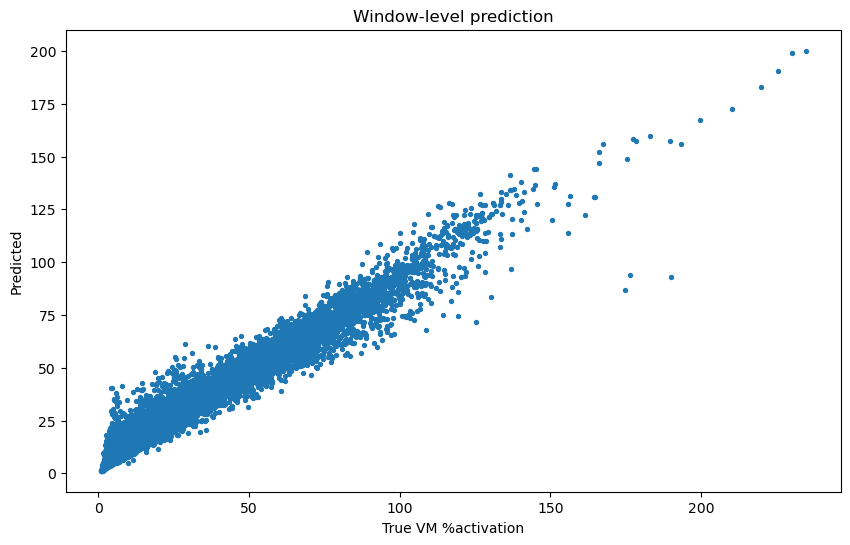

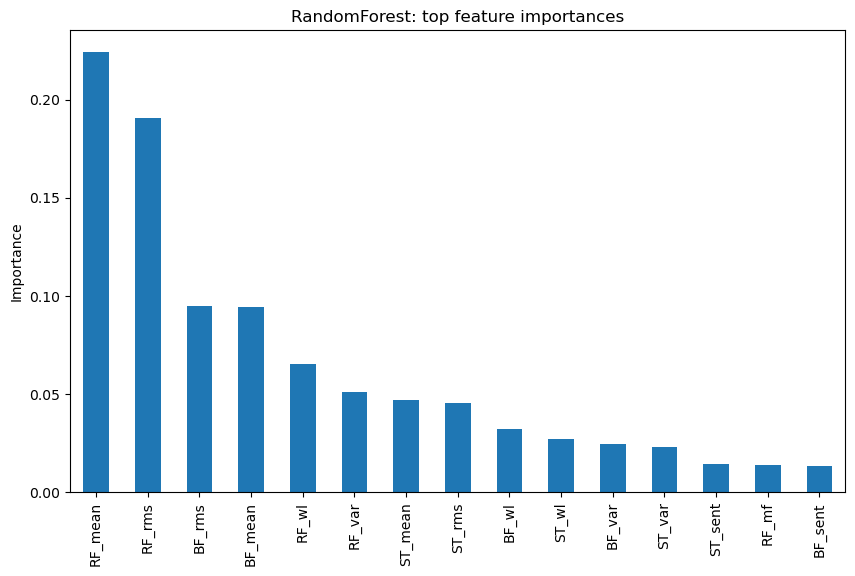


Best RF config: {'n_estimators': 800, 'max_depth': None, 'min_samples_leaf': 2, 'max_features': 'sqrt'} | CV R² mean: 0.488


In [3]:
# ======================================================
# Wearable EMG: Muscle Activation v2 — Robust, Tuned, 
# ======================================================

import os, re, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from io import StringIO
from scipy.signal import butter, filtfilt, iirnotch, savgol_filter, welch, find_peaks
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, r2_score

plt.rcParams['figure.figsize'] = (10, 6)

# ---------------- CONFIG ----------------
DATA_DIR = "SEMG_DB1 2/N_TXT"   # <<< set this to N_TXT folder
TARGET_MUSCLE = "VM"
PRED_CH = ['RF','BF','ST']

FS = 1000
BP_LOW, BP_HIGH = 20, 450
ENV_LP = 6
ROBUST_Q = 95
POWERLINE = 50
NOTCH_Q = 30

WIN_MS, HOP_MS = 200, 50
MIN_WINDOWS_FOR_TRAIN = 200
# ----------------------------------------

# ---------- 1) Robust file reader ----------
_num_re = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')
def _tokens(line):
    line = re.sub(r'(?<=\d),(?=\d)', '.', line)
    return _num_re.findall(line)

def read_emg_txt(path: str) -> pd.DataFrame:
    with open(path, 'r', errors='ignore') as f:
        lines = f.readlines()
    start = None
    for i, ln in enumerate(lines):
        if len(_tokens(ln)) >= 5:
            start = i; break
    if start is None:
        raise ValueError(f"No numeric data in {path}")
    rows = []
    for ln in lines[start:]:
        toks = _tokens(ln)
        if len(toks) >= 5: rows.append(' '.join(toks[:5]))
    arr = np.loadtxt(StringIO('\n'.join(rows)))
    if arr.ndim == 1: arr = arr.reshape(-1, 5)
    return pd.DataFrame(arr, columns=['RF','BF','VM','ST','FX'])

# ---------- 2) Filters & envelope ----------
def _safe_filtfilt(b, a, x):
    x = np.asarray(x, float)
    pad = 3*(max(len(a), len(b))-1)
    if x.size <= pad+1: return filtfilt(b,a,x,method="gust")
    return filtfilt(b,a,x)

def notch(sig, fs=FS, f0=50, q=NOTCH_Q):
    b,a = iirnotch(w0=f0/(fs/2), Q=q)
    return _safe_filtfilt(b,a,sig)

def bandpass(sig, fs=FS, low=BP_LOW, high=BP_HIGH, order=4):
    b,a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return _safe_filtfilt(b,a,sig)

def lowpass(sig, fs=FS, cutoff=ENV_LP, order=4):
    b,a = butter(order, cutoff/(fs/2), btype='low')
    return _safe_filtfilt(b,a,sig)

def emg_envelope(raw, fs=FS):
    x = np.asarray(raw,float)
    for f0 in [POWERLINE,2*POWERLINE,3*POWERLINE]:
        x = notch(x, fs, f0=f0)
    bp = bandpass(x,fs)
    rect = np.abs(bp)
    env = lowpass(rect,fs)
    return env

def to_percent_activation(env, q=ROBUST_Q):
    ref = np.percentile(env,q)
    return (env/(ref+1e-9))*100.0

def preprocess_file(path):
    df = read_emg_txt(path)
    env = {ch: emg_envelope(df[ch].values, FS) for ch in ['RF','BF','VM','ST']}
    pct = {ch: to_percent_activation(env[ch]) for ch in env}
    pct_df = pd.DataFrame(pct)
    pct_df['FX'] = df['FX'].values
    return df, pct_df

# ---------- 3) File discovery ----------
def list_txt_recursive(dd): return sorted(glob.glob(os.path.join(dd,"**","*.txt"), recursive=True))
def parse_len(path):
    try: return len(read_emg_txt(path))
    except: return 0

all_txt = list_txt_recursive(DATA_DIR)
parsable = [(p,parse_len(p)) for p in all_txt if parse_len(p)>0]
if not parsable: raise RuntimeError("No parsable .txt files under DATA_DIR")
parsable.sort(key=lambda x:x[1], reverse=True)
print("Top files by length:")
for p,n in parsable[:10]: print(" -", os.path.basename(p), n)

def subject_id(fname): 
    m = re.search(r'^(\d+)', fname)   # if filenames start with subject ID
    return m.group(1) if m else fname

# ---------- 4) Rep segmentation ----------
def segment_reps_fx(fx, fs=FS, min_rep_dur_s=0.5, height_q=60, pad_s=0.10):
    fx = np.asarray(fx).reshape(-1)
    fx = pd.Series(fx, dtype=float).interpolate().bfill().ffill().values
    win = 51 if len(fx)>51 else max(5,(len(fx)//2)*2-1)
    fx_s = savgol_filter(fx, window_length=win, polyorder=2, mode="interp")
    vel = np.gradient(fx_s)
    distance = int(fs*min_rep_dur_s)
    thr = np.percentile(np.abs(vel), height_q)
    peaks,_ = find_peaks(np.abs(vel), distance=distance, height=thr)
    pad = int(fs*pad_s)
    bounds=[]
    for i in range(0,len(peaks)-1,2):
        s=max(0,peaks[i]-pad); e=min(len(fx),peaks[i+1]+pad)
        if e-s>=distance: bounds.append((s,e))
    return bounds, vel

# ---------- 5) Safe phase split + rep metrics ----------
def split_phases_safe(s, e, vel, fs=FS, min_phase_s=0.12):
    s = int(max(0, s)); e = int(min(len(vel), e))
    if e - s < int(2*min_phase_s*fs):  # rep too short
        return None
    seg_vel = vel[s:e]
    zc = np.where(np.diff(np.sign(seg_vel)) != 0)[0]
    if len(zc)==0:
        mid = s + (e - s)//2
        ecc = (s, mid); con = (mid, e)
    else:
        k = s + zc[0]
        ecc = (s, k); con = (k, e)
    min_len = int(min_phase_s*fs)
    if ecc[1]-ecc[0] < min_len or con[1]-con[0] < min_len:
        mid2 = s + (e - s)//2
        ecc = (s, mid2); con = (mid2, e)
        if ecc[1]-ecc[0] < min_len or con[1]-con[0] < min_len:
            return None
    return ecc, con

def _stats_safe(arr):
    a = np.asarray(arr, float)
    if a.size == 0 or not np.isfinite(a).any():
        return None
    return float(np.nanmean(a)), float(np.nanmax(a))

def rep_metrics_safe(pct_df, s, e, vel, muscles=('RF','BF','VM','ST')):
    phases = split_phases_safe(s, e, vel, fs=FS, min_phase_s=0.12)
    if phases is None: return None
    (se, ee), (sc, ec) = phases
    out = {"t_s": s/FS, "t_e": e/FS, "dur": (e-s)/FS,
           "ecc_s": se/FS, "ecc_e": ee/FS, "con_s": sc/FS, "con_e": ec/FS}
    for m in muscles:
        for tag, (a0, a1) in [("rep",(s,e)), ("ecc",(se,ee)), ("con",(sc,ec))]:
            seg = pct_df[m].values[a0:a1]
            st  = _stats_safe(seg)
            if st is None: return None
            mean_v, peak_v = st
            out[f"{m}_{tag}_mean"] = mean_v
            out[f"{m}_{tag}_peak"] = peak_v
    return out

# ---------- 6) Sliding-window features ----------
def sliding_windows(n,win,hop):
    for i in range(0,n-win+1,hop): yield i,i+win

def feats_time(arr):
    a=np.asarray(arr,float)
    return {"mean":float(np.nanmean(a)),
            "rms":float(np.sqrt(np.nanmean(a**2))),
            "var":float(np.nanvar(a)),
            "wl":float(np.nansum(np.abs(np.diff(a))))}

def feats_freq(arr,fs=FS):
    a=np.asarray(arr,float)
    if np.nanstd(a)<1e-9: return {"mf":0.0,"sent":0.0}
    f,pxx=welch(a,fs=fs,nperseg=min(512,len(a)))
    pxx=np.maximum(pxx,1e-12)
    cs=np.cumsum(pxx); half=cs[-1]/2.0
    mf=float(np.interp(half,cs,f))
    P=pxx/pxx.sum(); sent=float(-(P*np.log(P)).sum()/np.log(len(P)))
    return {"mf":mf,"sent":sent}

def build_window_dataset(pct_df,win_ms=WIN_MS,hop_ms=HOP_MS):
    win=int(FS*win_ms/1000); hop=int(FS*hop_ms/1000)
    rows,ys,idxs=[],[],[]
    for s,e in sliding_windows(len(pct_df),win,hop):
        feat={}; ok=True
        for ch in PRED_CH:
            w=pct_df[ch].values[s:e]
            if np.nanstd(w)<1e-9: ok=False; break
            feat.update({f"{ch}_{k}":v for k,v in feats_time(w).items()})
            feat.update({f"{ch}_{k}":v for k,v in feats_freq(w).items()})
        if not ok: continue
        ys.append(float(np.nanmean(pct_df[TARGET_MUSCLE].values[s:e])))
        rows.append(feat); idxs.append((s,e))
    return pd.DataFrame(rows), np.array(ys,float), idxs

# ---------- 7) Build datasets across ALL files ----------
files=[p for p,_ in parsable]  # use all
all_X, all_y, groups, win_meta = [], [], [], []
rep_rows_all = []

for path in files:
    base=os.path.basename(path); sid=subject_id(base)
    _, pct = preprocess_file(path)

    reps, vel = segment_reps_fx(pct['FX'].values, fs=FS, min_rep_dur_s=0.45, height_q=55, pad_s=0.10)
    if len(reps)==0:
        reps, vel = segment_reps_fx(pct['FX'].values, fs=FS, min_rep_dur_s=0.35, height_q=40, pad_s=0.08)
    for (s,e) in reps:
        row = rep_metrics_safe(pct, s, e, vel)
        if row is None: continue
        rep_rows_all.append({"file":base,"sid":sid, **row})

    X,y,idxs = build_window_dataset(pct, win_ms=WIN_MS, hop_ms=HOP_MS)
    if len(X)==0:
        X,y,idxs = build_window_dataset(pct, win_ms=100, hop_ms=25)
    if len(X)==0: 
        continue
    all_X.append(X); all_y.append(y); groups += [sid]*len(X)
    win_meta += [(base,sid,s,e) for (s,e) in idxs]

rep_table = pd.DataFrame(rep_rows_all)
Xg = pd.concat(all_X, ignore_index=True) if all_X else pd.DataFrame()
yg = np.concatenate(all_y) if all_y else np.array([])
groups = np.array(groups)

print(f"Reps: {len(rep_table)} | Windows: {len(Xg)} | Features: {Xg.shape[1] if len(Xg) else 0} | Subjects: {len(np.unique(groups))}")

if len(Xg) < MIN_WINDOWS_FOR_TRAIN:
    raise RuntimeError("Too few windows for training. Check DATA_DIR or window config.")

# ---------- 8) Learn data-driven engagement bands ----------
def learn_bands(df, muscle="VM", pref="rep", qlo=0.30, qhi=0.70, margin=0.1):
    col = f"{muscle}_{pref}_mean"
    vals = df[col].dropna() if col in df.columns else pd.Series([], dtype=float)
    if len(vals) < 30: return (40, 60)
    lo, hi = vals.quantile(qlo), vals.quantile(qhi)
    span = hi - lo
    return (max(0, lo - margin*span), min(1000, hi + margin*span))

def flag_engagement(v, band, tol=5):
    lo, hi = band
    if v < lo - tol: return "under"
    if v > hi + tol: return "over"
    return "optimal"

bands = {m: learn_bands(rep_table, muscle=m) for m in ['VM','RF','BF','ST']} if not rep_table.empty else {}
print("Bands learned:", bands)

# ---------- 9) RF tuning (GroupKFold by subject) ----------
param_grid = [
    {"n_estimators": 400, "max_depth": None, "min_samples_leaf": 2, "max_features": "sqrt"},
    {"n_estimators": 800, "max_depth": None, "min_samples_leaf": 2, "max_features": "sqrt"},
    {"n_estimators": 600, "max_depth": 20,   "min_samples_leaf": 2, "max_features": "sqrt"},
    {"n_estimators": 600, "max_depth": None, "min_samples_leaf": 1, "max_features": None},
]
n_splits = min(5, max(3, len(np.unique(groups))))
gkf = GroupKFold(n_splits=n_splits)

best_cfg, best_r2 = None, -1e9
cv_rows = []
for cfg in param_grid:
    fold_r2 = []
    for tr, te in gkf.split(Xg, yg, groups=groups):
        rf = RandomForestRegressor(random_state=42, n_jobs=-1, **cfg)
        rf.fit(Xg.iloc[tr], yg[tr])
        pred = rf.predict(Xg.iloc[te])
        fold_r2.append(r2_score(yg[te], pred))
    mean_r2 = float(np.mean(fold_r2))
    cv_rows.append({"cfg": cfg, "R2_mean": mean_r2})
    if mean_r2 > best_r2: best_r2, best_cfg = mean_r2, cfg

cv_df = pd.DataFrame(cv_rows).sort_values("R2_mean", ascending=False)
print("\nRF CV (by subject) — top configs:\n", cv_df)

# Fit best RF on ALL data
rf_best = RandomForestRegressor(random_state=42, n_jobs=-1, **best_cfg).fit(Xg, yg)

# ---------- 10) Quantile models for prediction intervals ----------
gb_lower = GradientBoostingRegressor(loss="quantile", alpha=0.10, random_state=42, max_depth=3, n_estimators=400)
gb_upper = GradientBoostingRegressor(loss="quantile", alpha=0.90, random_state=42, max_depth=3, n_estimators=400)
gb_lower.fit(Xg, yg); gb_upper.fit(Xg, yg)

# Window-level predictions
y_pred_mean = rf_best.predict(Xg)
y_pred_lo   = gb_lower.predict(Xg)
y_pred_hi   = gb_upper.predict(Xg)

win_pred = pd.DataFrame({
    "file":[m[0] for m in win_meta],
    "sid":[m[1] for m in win_meta],
    "s":[m[2] for m in win_meta],
    "e":[m[3] for m in win_meta],
    "y_true": yg,
    "y_pred": y_pred_mean,
    "y_lo": y_pred_lo,
    "y_hi": y_pred_hi
})

# ---------- 11) Aggregate to per‑rep predictions + flags ----------
from collections import defaultdict
reps_by_file = defaultdict(list)
for _, r in rep_table.iterrows():
    reps_by_file[r["file"]].append((r["t_s"], r["t_e"]))

def sec_to_samp(sec): return int(round(sec * FS))

agg_rows = []
for f, sid, s, e, yhat, lo, hi in win_pred[["file","sid","s","e","y_pred","y_lo","y_hi"]].itertuples(index=False):
    best_rep, best_overlap = None, 0
    for (ts, te) in reps_by_file.get(f, []):
        rs, re = sec_to_samp(ts), sec_to_samp(te)
        ov = max(0, min(e, re) - max(s, rs))
        if ov > best_overlap:
            best_overlap, best_rep = ov, (ts, te)
    if best_rep is None:
        continue
    agg_rows.append((f, sid, best_rep[0], best_rep[1], yhat, lo, hi))

rep_pred = pd.DataFrame(agg_rows, columns=["file","sid","t_s","t_e","y_pred","y_lo","y_hi"])
rep_pred = rep_pred.groupby(["file","sid","t_s","t_e"], as_index=False).agg(
    y_pred=("y_pred","mean"), y_lo=("y_lo","mean"), y_hi=("y_hi","mean")
)

# Join with measured per-rep VM (if present) and flag
if not rep_table.empty and "VM_rep_mean" in rep_table.columns:
    rep_eval = rep_table.merge(rep_pred, on=["file","sid","t_s","t_e"], how="left")
    has_pred = rep_eval.dropna(subset=["y_pred"])
    if len(has_pred) > 0:
        print("\nPer‑rep eval on available truth:")
        print("MAE:", mean_absolute_error(has_pred["VM_rep_mean"], has_pred["y_pred"]))
        print("R² :", r2_score(has_pred["VM_rep_mean"], has_pred["y_pred"]))
else:
    rep_eval = rep_pred.copy()

vm_band = bands.get("VM", (40, 60))
rep_eval["VM_flag"] = rep_eval["y_pred"].apply(lambda v: flag_engagement(v, vm_band))

# ---------- 12) Save outputs ----------
os.makedirs("outputs", exist_ok=True)
rep_table.to_csv("outputs/rep_metrics_v2.csv", index=False)
Xg.head(500).to_csv("outputs/window_dataset_preview_v2.csv", index=False)
win_pred.to_csv("outputs/window_predictions_with_intervals.csv", index=False)
rep_eval.to_csv("outputs/per_rep_predictions.csv", index=False)
with open("outputs/per_rep_predictions.json","w") as f:
    json.dump(rep_eval.to_dict(orient="records"), f, indent=2)
print("\nSaved to outputs/: rep_metrics_v2.csv, window_dataset_preview_v2.csv, window_predictions_with_intervals.csv, per_rep_predictions.(csv/json)")

# ---------- 13) Quick plots ----------
plt.figure(); plt.scatter(win_pred["y_true"], win_pred["y_pred"], s=8)
plt.xlabel(f"True {TARGET_MUSCLE} %activation"); plt.ylabel("Predicted")
plt.title("Window-level prediction"); plt.show()

# RF importances (HGB has none)
fi = pd.Series(rf_best.feature_importances_, index=Xg.columns).sort_values(ascending=False)
plt.figure(); fi.head(15).plot(kind="bar"); plt.title("RandomForest: top feature importances"); plt.ylabel("Importance"); plt.show()

print("\nBest RF config:", best_cfg, "| CV R² mean:", round(best_r2, 3))

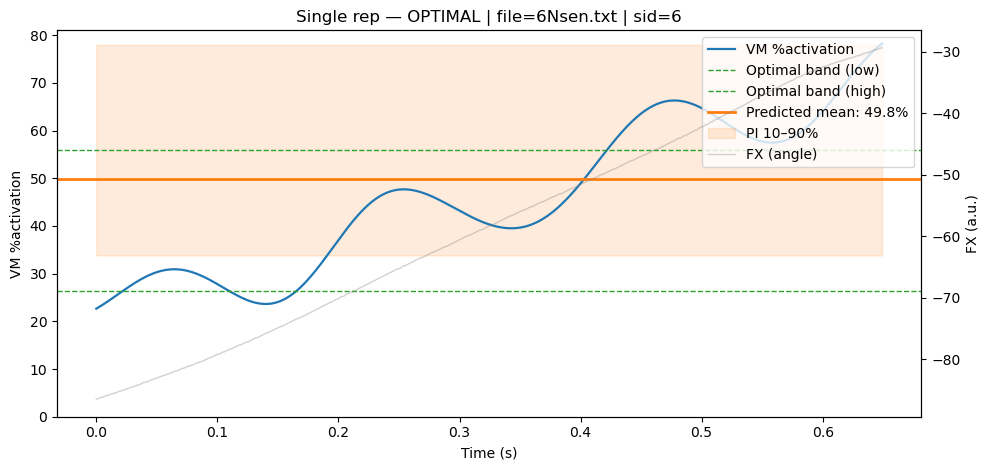

[single] file=6Nsen.txt sid=6  start=7.07s  end=7.72s  pred=49.8%  PI10–90=(33.8,78.0)  flag=optimal  band=(26.31996528524478, 55.905455302221405)


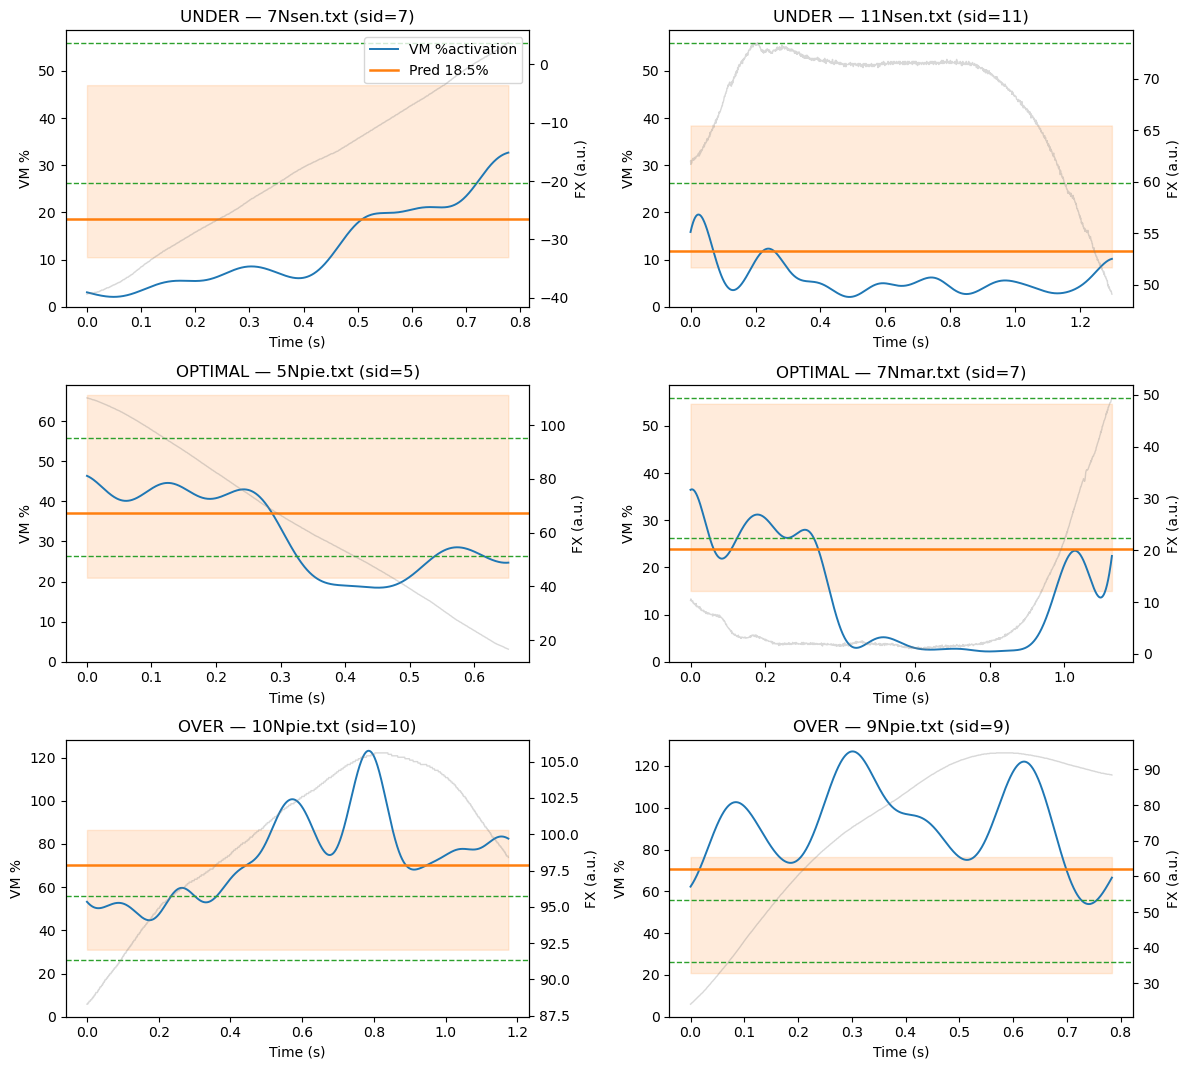

In [4]:
# ======================================================
# 14) ONE-CELL VISUALS (self-contained loader to avoid _tokens conflicts)
#    - Single random rep
#    - Multipanel (under / optimal / over)
# ======================================================

import os, re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO


# ---------- local, conflict-free reader JUST for visualization ----------
_num_re_viz = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')

def parse_tokens_viz(line: str):
    line = re.sub(r'(?<=\d),(?=\d)', '.', line)
    return _num_re_viz.findall(line)

def viz_read_emg_txt(path: str) -> pd.DataFrame:
    with open(path, 'r', errors='ignore') as f:
        lines = f.readlines()
    start = None
    for i, ln in enumerate(lines):
        if len(parse_tokens_viz(ln)) >= 5:
            start = i; break
    if start is None:
        raise ValueError(f"No numeric data in {path}")
    rows = []
    for ln in lines[start:]:
        toks = parse_tokens_viz(ln)
        if len(toks) >= 5:
            rows.append(' '.join(toks[:5]))
    arr = np.loadtxt(StringIO('\n'.join(rows)))
    if arr.ndim == 1: arr = arr.reshape(-1, 5)
    return pd.DataFrame(arr, columns=['RF','BF','VM','ST','FX'])

def viz_preprocess_file(path, fs=FS, q=95):
    df = viz_read_emg_txt(path)
    env = {ch: emg_envelope(df[ch].values, fs) for ch in ['RF','BF','VM','ST']}
    pct = {}
    for ch in env:
        ref = np.percentile(env[ch], q)
        pct[ch] = (env[ch] / (ref + 1e-9)) * 100.0
    pct_df = pd.DataFrame(pct)
    pct_df['FX'] = df['FX'].values
    return df, pct_df

# ---------- build file lookup (base -> full path) ----------
# Prefer the parsable list from your pipeline. If missing, scan DATA_DIR.
try:
    file_lookup = {os.path.basename(p): p for p, _ in parsable}
except NameError:
    # fallback: try to infer DATA_DIR from earlier cells; else ask to set
    try:
        DATA_DIR
    except NameError:
        raise RuntimeError("DATA_DIR is not defined. Set it to your .../N_TXT folder.")
    all_txt = sorted(glob.glob(os.path.join(DATA_DIR, "**", "*.txt"), recursive=True))
    file_lookup = {os.path.basename(p): p for p in all_txt}

# ---------- utility ----------
def ensure_flags(df, band, col_pred="y_pred", out_col="VM_flag", tol=5):
    df = df.copy()
    if out_col not in df.columns or df[out_col].isna().all():
        lo, hi = band
        def _flag(v):
            if not np.isfinite(v): return np.nan
            if v < lo - tol: return "under"
            if v > hi + tol: return "over"
            return "optimal"
        df[out_col] = df[col_pred].apply(_flag)
    return df

def sec_to_samp(sec):  # in case it wasn't in scope
    return int(round(float(sec) * FS))

def load_rep_slice_viz(row_dict):
    fbase = row_dict["file"]
    if fbase not in file_lookup:
        raise FileNotFoundError(f"Cannot find full path for file '{fbase}'.")
    path = file_lookup[fbase]
    _, pct = viz_preprocess_file(path)   # <-- uses the conflict-free loader
    s = max(0, sec_to_samp(row_dict["t_s"]))
    e = max(s+1, sec_to_samp(row_dict["t_e"]))
    e = min(e, len(pct))
    vm = pct["VM"].values[s:e]
    fx = pct["FX"].values[s:e]
    t  = np.arange(e - s) / FS
    return t, vm, fx

# ---------- prepare data ----------
if 'rep_eval' not in globals():
    raise RuntimeError("rep_eval not found. Run the modeling cells first.")
if 'bands' not in globals():
    raise RuntimeError("bands not found. Run the band-learning cell first.")
TARGET_BAND = bands.get("VM", (40, 60))

vis_df = rep_eval.copy()
if "y_pred" not in vis_df.columns or vis_df["y_pred"].isna().all():
    raise RuntimeError("No predictions in rep_eval (y_pred missing). Run the modeling cells first.")
vis_df = vis_df.dropna(subset=["y_pred"]).copy()
vis_df = ensure_flags(vis_df, TARGET_BAND)

# ======================================================
# 14a) Single random rep
# ======================================================
rng = np.random.default_rng(RANDOM_SEED if 'RANDOM_SEED' in globals() else 7)
row = vis_df.sample(1, random_state=int(rng.integers(0, 10_000))).iloc[0]
rowd = row.to_dict()

t, vm, fx = load_rep_slice_viz(rowd)
yhat = float(rowd.get("y_pred", np.nan))
lo   = float(rowd.get("y_lo", np.nan)) if "y_lo" in rowd else np.nan
hi   = float(rowd.get("y_hi", np.nan)) if "y_hi" in rowd else np.nan
flag = rowd.get("VM_flag", "unknown")
fbase= rowd["file"]
sid  = rowd.get("sid", "NA")

fig, ax1 = plt.subplots(figsize=(10, 4.8))
ax1.plot(t, vm, lw=1.6, label="VM %activation")
ax1.axhline(TARGET_BAND[0], color="tab:green", ls="--", lw=1, label="Optimal band (low)")
ax1.axhline(TARGET_BAND[1], color="tab:green", ls="--", lw=1, label="Optimal band (high)")
if np.isfinite(yhat):
    ax1.axhline(yhat, color="tab:orange", lw=2, label=f"Predicted mean: {yhat:.1f}%")
if np.isfinite(lo) and np.isfinite(hi):
    ax1.fill_between(t, lo, hi, color="tab:orange", alpha=0.15, label=f"PI 10–90%")
ax1.set_xlabel("Time (s)"); ax1.set_ylabel("VM %activation"); ax1.set_ylim(bottom=0)
ax1.set_title(f"Single rep — {flag.upper()} | file={fbase} | sid={sid}")

ax2 = ax1.twinx()
ax2.plot(t, fx, color="tab:gray", alpha=0.35, lw=1, label="FX (angle)")
ax2.set_ylabel("FX (a.u.)")

h1,l1 = ax1.get_legend_handles_labels(); h2,l2 = ax2.get_legend_handles_labels()
uniq = dict(zip(l1 + l2, h1 + h2))
ax1.legend(uniq.values(), uniq.keys(), loc="upper right")
plt.tight_layout(); plt.show()

print(f"[single] file={fbase} sid={sid}  start={rowd['t_s']:.2f}s  end={rowd['t_e']:.2f}s  "
      f"pred={yhat:.1f}%  PI10–90=({lo:.1f},{hi:.1f})  flag={flag}  band={TARGET_BAND}")

# ======================================================
# 14b) Multipanel: under / optimal / over (up to MAX_PER_FLAG each)
# ======================================================
FLAGS_TO_SHOW = ["under", "optimal", "over"]
MAX_PER_FLAG  = 2

examples = []
for flg in FLAGS_TO_SHOW:
    cand = vis_df[vis_df["VM_flag"] == flg]
    if len(cand) == 0:
        print(f" No examples for flag '{flg}' — skipping.")
        continue
    take = min(MAX_PER_FLAG, len(cand))
    # use numpy RNG to avoid pandas sampling state dependence
    sel_idx = rng.choice(cand.index.values, size=take, replace=False)
    examples += list(cand.loc[sel_idx].to_dict(orient="records"))

if len(examples) == 0:
    print("No multipanel examples available (not enough flagged reps).")
else:
    n = len(examples); cols = MAX_PER_FLAG; rows = int(np.ceil(n/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 3.6*rows), squeeze=False)

    for i, rec in enumerate(examples):
        ax = axes[i//cols][i%cols]
        try:
            t, vm, fx = load_rep_slice_viz(rec)
        except Exception as e:
            ax.text(0.5, 0.5, f"Load error:\n{e}", ha='center', va='center')
            ax.axis("off")
            continue

        yhat = float(rec.get("y_pred", np.nan))
        lo   = float(rec.get("y_lo", np.nan)) if "y_lo" in rec else np.nan
        hi   = float(rec.get("y_hi", np.nan)) if "y_hi" in rec else np.nan
        flag = rec.get("VM_flag", "unknown")
        fbase= rec["file"]; sid = rec.get("sid", "NA")

        ax.plot(t, vm, lw=1.4, label="VM %activation")
        ax.axhline(TARGET_BAND[0], color="tab:green", ls="--", lw=1)
        ax.axhline(TARGET_BAND[1], color="tab:green", ls="--", lw=1)
        if np.isfinite(yhat):
            ax.axhline(yhat, color="tab:orange", lw=1.8, label=f"Pred {yhat:.1f}%")
        if np.isfinite(lo) and np.isfinite(hi):
            ax.fill_between(t, lo, hi, color="tab:orange", alpha=0.15)
        ax.set_title(f"{flag.upper()} — {fbase} (sid={sid})")
        ax.set_xlabel("Time (s)"); ax.set_ylabel("VM %"); ax.set_ylim(bottom=0)

        ax2 = ax.twinx()
        ax2.plot(t, fx, color="tab:gray", alpha=0.3, lw=1)
        ax2.set_ylabel("FX (a.u.)")

    # legend from first axis if available
    first_ax = axes[0][0]
    h, l = first_ax.get_legend_handles_labels()
    if len(h) > 0:
        first_ax.legend(h, l, loc="upper right")

    plt.tight_layout(); plt.show()

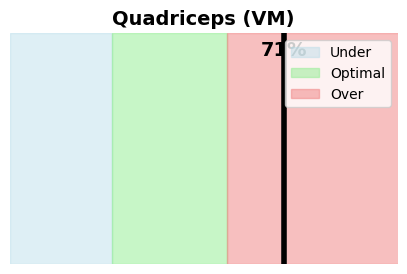

In [5]:
import matplotlib.pyplot as plt

def plot_gauge(value, band=(40,60), label="VM Activation"):
    fig, ax = plt.subplots(figsize=(5,3))
    ax.set_xlim(0,100); ax.set_ylim(0,1)
    
    # background zones
    ax.axvspan(0, band[0], color="lightblue", alpha=0.4, label="Under")
    ax.axvspan(band[0], band[1], color="lightgreen", alpha=0.5, label="Optimal")
    ax.axvspan(band[1], 120, color="lightcoral", alpha=0.5, label="Over")
    
    # pointer
    ax.plot([value, value],[0,1], color="black", lw=4)
    ax.text(value, 0.9, f"{value:.0f}%", ha="center", fontsize=14, weight="bold")
    
    ax.axis("off")
    ax.set_title(f"{label}", fontsize=14, weight="bold")
    plt.legend(loc="upper right")
    plt.show()

# Example: use the predicted value from your single rep
plot_gauge(yhat, band=TARGET_BAND, label="Quadriceps (VM)")

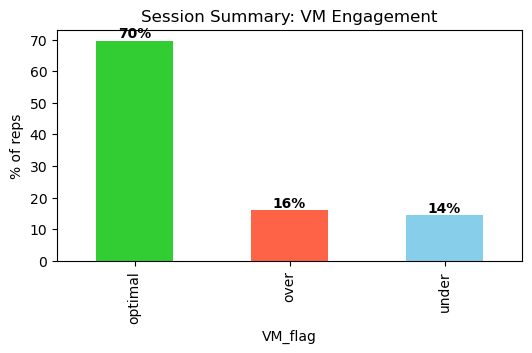

In [6]:
summary = rep_eval["VM_flag"].value_counts(normalize=True) * 100
colors = {"under":"skyblue","optimal":"limegreen","over":"tomato"}

fig, ax = plt.subplots(figsize=(6,3))
summary.plot(kind="bar", color=[colors.get(c,"gray") for c in summary.index], ax=ax)
ax.set_ylabel("% of reps")
ax.set_title("Session Summary: VM Engagement")
for i,v in enumerate(summary):
    ax.text(i, v+1, f"{v:.0f}%", ha="center", weight="bold")
plt.show()

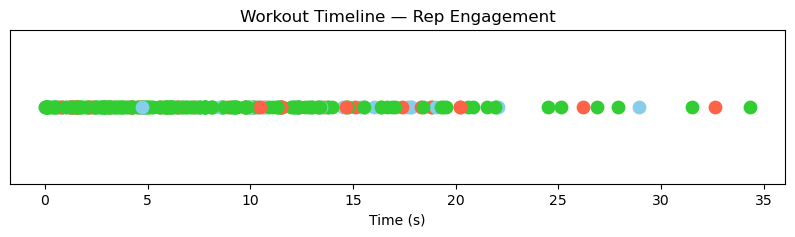

In [7]:
fig, ax = plt.subplots(figsize=(10,2))
colors = {"under":"skyblue","optimal":"limegreen","over":"tomato"}
for i,row in rep_eval.iterrows():
    ax.scatter(row["t_s"], 1, color=colors.get(row["VM_flag"],"gray"), s=80)

ax.set_yticks([])
ax.set_xlabel("Time (s)")
ax.set_title("Workout Timeline — Rep Engagement")
plt.show()

/var/folders/pc/gb2h3yqd1114ct9bz8zdd6040000gn/T/ipykernel_77073/4023818992.py:153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


Saved: outputs/athlete_report.png


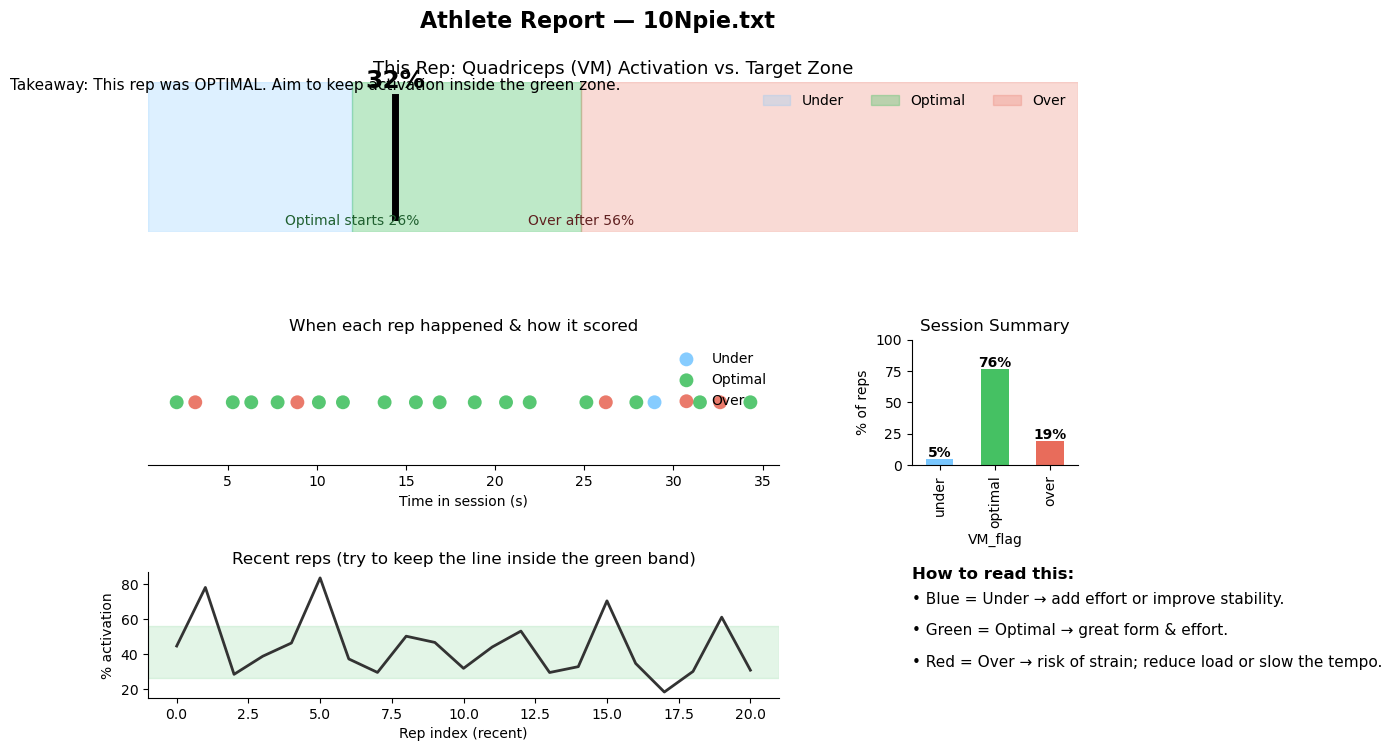

In [8]:
# ===================== Athlete Report (loads from outputs/) =====================
# What it does:
#  - Loads per_rep_predictions.csv (required) and rep_metrics_v2.csv (optional)
#  - Learns a VM "optimal band" from your data (or uses a sensible fallback)
#  - Builds a clean, simple report for non-technical viewers
#  - Saves a PNG at outputs/athlete_report.png

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ---------- settings ----------
OUTPUTS_DIR   = "outputs"                       # change if you saved elsewhere
PRED_CSV      = os.path.join(OUTPUTS_DIR, "per_rep_predictions.csv")
METRICS_CSV   = os.path.join(OUTPUTS_DIR, "rep_metrics_v2.csv")   # optional
RANDOM_SEED   = 7
SESSION_FIELD = "file"                           # group the report by file (or "sid")
SAVE_PNG      = True
SAVE_PATH     = os.path.join(OUTPUTS_DIR, "athlete_report.png")

# ---------- load data ----------
if not os.path.exists(PRED_CSV):
    raise FileNotFoundError(
        f"Could not find {PRED_CSV}.\n"
        "Run your modeling notebook first so it writes per_rep_predictions.csv to outputs/."
    )

rep_eval = pd.read_csv(PRED_CSV)

metrics_df = pd.read_csv(METRICS_CSV) if os.path.exists(METRICS_CSV) else None

# ---------- learn (or set) the VM "optimal" band ----------
def learn_band_from_metrics(df, muscle="VM", pref="rep", qlo=0.30, qhi=0.70, margin=0.10):
    col = f"{muscle}_{pref}_mean"
    if df is None or col not in df.columns or df[col].dropna().empty:
        return None
    vals = df[col].dropna()
    lo, hi = vals.quantile(qlo), vals.quantile(qhi)
    span = hi - lo
    return (max(0, lo - margin*span), min(1000, hi + margin*span))

# try to learn from ground-truth metrics; else learn from predicted y_pred; else fallback
VM_BAND = learn_band_from_metrics(metrics_df, "VM", "rep")
if VM_BAND is None:
    if "y_pred" in rep_eval.columns and rep_eval["y_pred"].notna().any():
        vals = rep_eval["y_pred"].dropna()
        lo, hi = vals.quantile(0.30), vals.quantile(0.70)
        span = hi - lo
        VM_BAND = (max(0, lo - 0.10*span), min(1000, hi + 0.10*span))
    else:
        VM_BAND = (40, 60)  # safe default if nothing else is available

# ---------- add flags if missing ----------
def add_flags(df, band, col="y_pred", tol=5):
    out = df.copy()
    if "VM_flag" not in out.columns or out["VM_flag"].isna().all():
        lo, hi = band
        def _flag(v):
            if not np.isfinite(v): return np.nan
            if v < lo - tol: return "under"
            if v > hi + tol: return "over"
            return "optimal"
        out["VM_flag"] = out[col].apply(_flag)
    return out

rep_eval = add_flags(rep_eval, VM_BAND)

# ---------- choose a session to display ----------
if rep_eval.empty or rep_eval["y_pred"].isna().all():
    raise RuntimeError("per_rep_predictions.csv has no predictions to visualize.")

session_counts = rep_eval[SESSION_FIELD].value_counts()
session_key = session_counts.idxmax()  # file with most reps
sess_df = rep_eval[rep_eval[SESSION_FIELD] == session_key].dropna(subset=["y_pred"]).copy()
if sess_df.empty:  # fallback: use everything
    sess_df = rep_eval.dropna(subset=["y_pred"]).copy()
    session_key = f"All sessions ({rep_eval[SESSION_FIELD].nunique()} files)"

# ---------- colors & helpers ----------
C = {"under":"#79C7FF", "optimal":"#45C163", "over":"#E86C5B"}
def nice_pct(x): return f"{x:.0f}%"
rng = np.random.default_rng(RANDOM_SEED)

# ============================ build the figure ============================
fig = plt.figure(figsize=(12, 8))
gs  = fig.add_gridspec(nrows=3, ncols=3, height_ratios=[1.2, 1, 1], width_ratios=[2,1,1], hspace=0.8, wspace=0.6)
title = f"Athlete Report — {session_key}"
fig.suptitle(title, fontsize=16, weight="bold", y=0.97)

# ---- 1) PER-REP GAUGE (top row, full width) ----
ax_g = fig.add_subplot(gs[0, :])
row = sess_df.iloc[len(sess_df)//2]  # pick a mid-session rep
value = float(row["y_pred"])
lo, hi = VM_BAND

ax_g.set_xlim(0, max(120, hi+20)); ax_g.set_ylim(0, 1)
ax_g.axvspan(0, lo, color=C["under"],   alpha=0.25, label="Under")
ax_g.axvspan(lo, hi, color=C["optimal"], alpha=0.35, label="Optimal")
ax_g.axvspan(hi, max(120, hi+20), color=C["over"], alpha=0.25, label="Over")
ax_g.plot([value, value], [0.1, 0.9], color="black", lw=5)
ax_g.text(value, 0.93, f"{value:.0f}%", ha="center", va="bottom", fontsize=18, weight="bold")
ax_g.text(lo, 0.05, f"Optimal starts {lo:.0f}%", ha="center", fontsize=10, color="#206030")
ax_g.text(hi, 0.05, f"Over after {hi:.0f}%",   ha="center", fontsize=10, color="#602020")
ax_g.axis("off")
ax_g.legend(loc="upper right", ncols=3, frameon=False)
flag = row.get("VM_flag", "optimal").upper()
ax_g.set_title("This Rep: Quadriceps (VM) Activation vs. Target Zone", fontsize=13)
fig.text(0.01, 0.87, f"Takeaway: This rep was {flag}. Aim to keep activation inside the green zone.", fontsize=11)

# ---- 2) SESSION SUMMARY BAR (right column) ----
ax_bar = fig.add_subplot(gs[1, 2])
summary = sess_df["VM_flag"].value_counts(normalize=True).reindex(["under","optimal","over"]).fillna(0)*100
summary.plot(kind="bar", color=[C.get(k,"#888") for k in summary.index], ax=ax_bar)
ax_bar.set_ylim(0, 100)
ax_bar.set_ylabel("% of reps")
ax_bar.set_title("Session Summary")
for i, v in enumerate(summary):
    ax_bar.text(i, v+2, nice_pct(v), ha="center", weight="bold")
ax_bar.spines[['top','right']].set_visible(False)

# ---- 3) TIMELINE OF REPS (left two panels) ----
ax_time = fig.add_subplot(gs[1, :2])
x = sess_df["t_s"].values
y = np.zeros_like(x)
for flg in ["under","optimal","over"]:
    m = (sess_df["VM_flag"].values == flg)
    if m.any():
        ax_time.scatter(x[m], y[m], s=100, color=C[flg], label=flg.capitalize(), alpha=0.9, edgecolor="none")
ax_time.set_yticks([])
ax_time.set_xlabel("Time in session (s)")
ax_time.set_title("When each rep happened & how it scored")
ax_time.legend(loc="upper right", frameon=False)
ax_time.spines[['top','right','left']].set_visible(False)

# ---- 4) Guidance box (bottom right) ----
ax_note = fig.add_subplot(gs[2, 2]); ax_note.axis("off")
tips = [
    "Blue = Under → add effort or improve stability.",
    "Green = Optimal → great form & effort.",
    "Red = Over → risk of strain; reduce load or slow the tempo.",
]
ax_note.text(0, 0.95, "How to read this:", fontsize=12, weight="bold")
for i, t_ in enumerate(tips):
    ax_note.text(0, 0.75 - i*0.25, f"• {t_}", fontsize=11)

# ---- 5) Recent reps sparkline (bottom left wide) ----
ax_spark = fig.add_subplot(gs[2, :2])
last = sess_df.tail(min(25, len(sess_df)))
ax_spark.plot(np.arange(len(last)), last["y_pred"].values, lw=2, color="#333")
ax_spark.axhspan(lo, hi, color=C["optimal"], alpha=0.15, zorder=0)
ax_spark.set_title("Recent reps (try to keep the line inside the green band)")
ax_spark.set_ylabel("% activation"); ax_spark.set_xlabel("Rep index (recent)")
ax_spark.spines[['top','right']].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 1])

if SAVE_PNG:
    os.makedirs(OUTPUTS_DIR, exist_ok=True)
    plt.savefig(SAVE_PATH, dpi=160)
    print(f"Saved: {SAVE_PATH}")

plt.show()
# ======================================================================


/var/folders/pc/gb2h3yqd1114ct9bz8zdd6040000gn/T/ipykernel_77073/376739793.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


Saved: outputs/athlete_report_VM.png


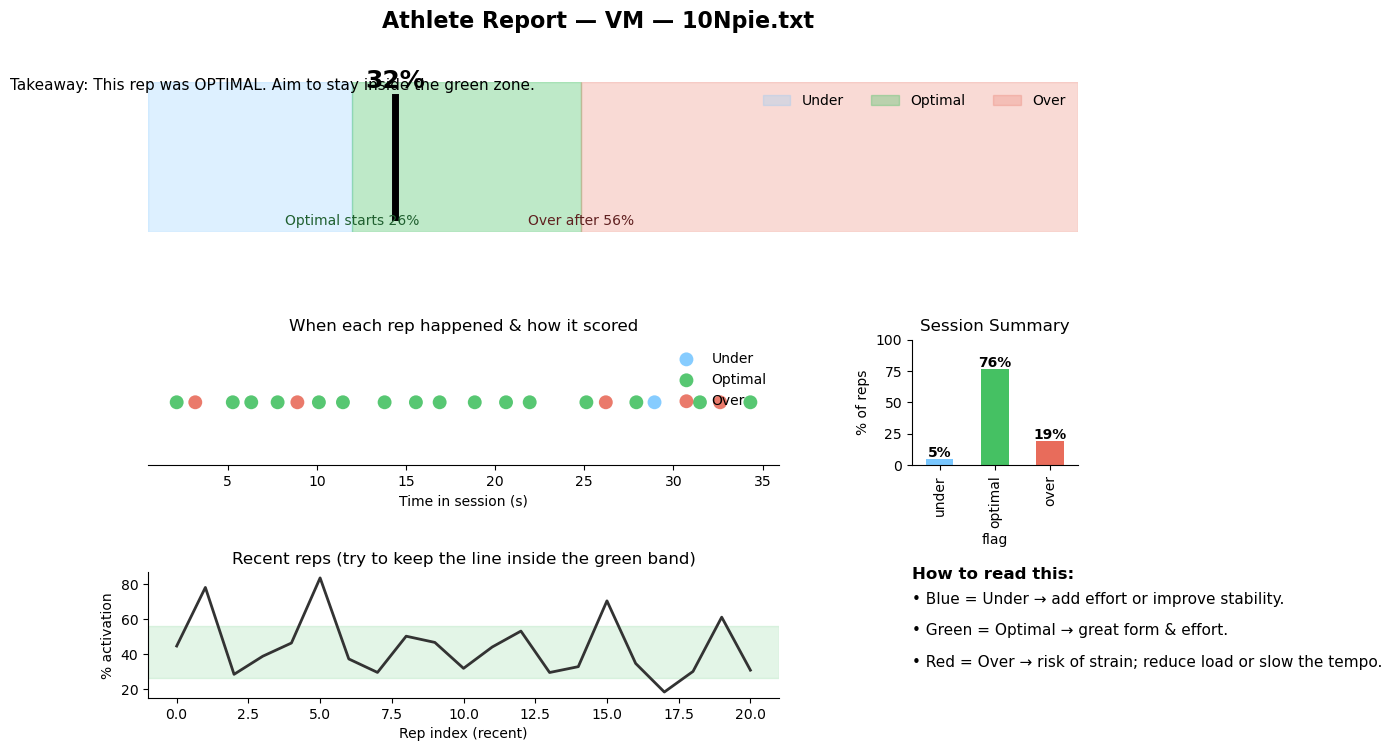

/var/folders/pc/gb2h3yqd1114ct9bz8zdd6040000gn/T/ipykernel_77073/376739793.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


Saved: outputs/athlete_report_RF.png


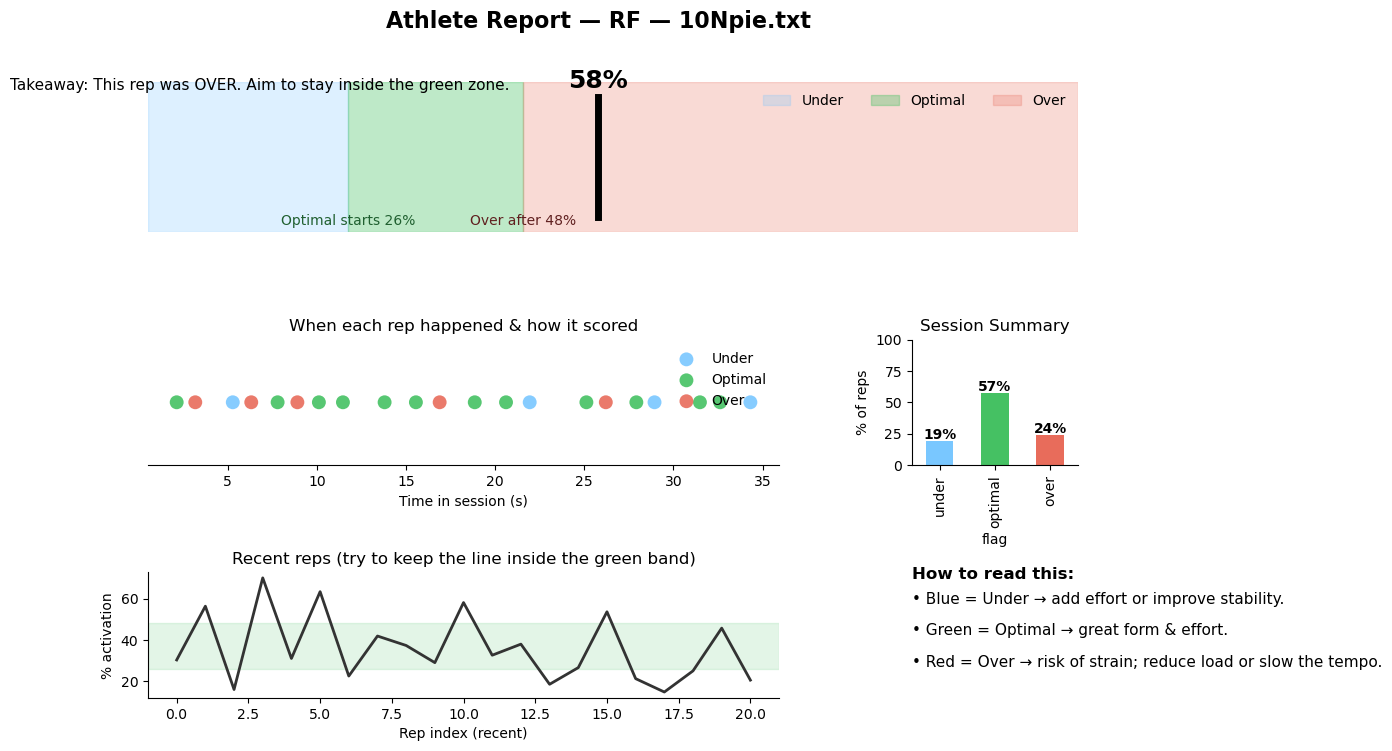

/var/folders/pc/gb2h3yqd1114ct9bz8zdd6040000gn/T/ipykernel_77073/376739793.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


Saved: outputs/athlete_report_BF.png


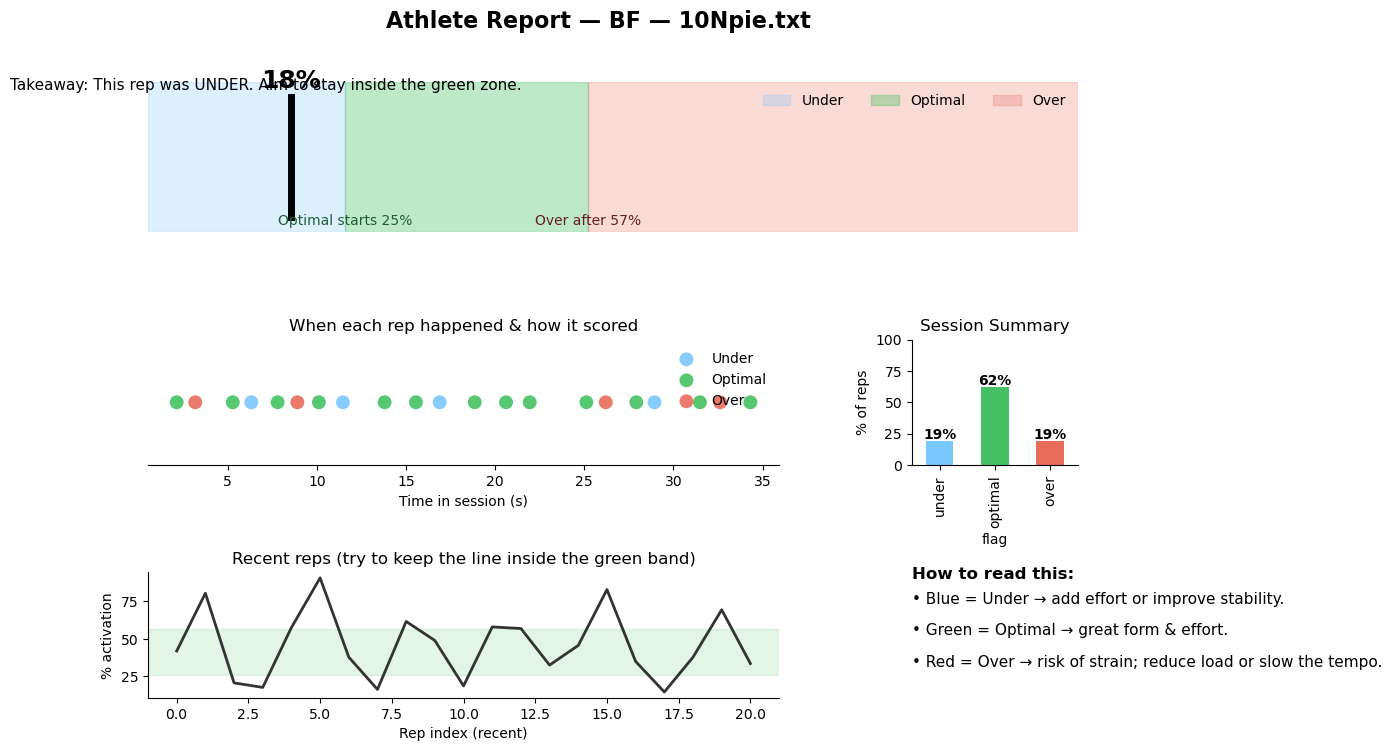

/var/folders/pc/gb2h3yqd1114ct9bz8zdd6040000gn/T/ipykernel_77073/376739793.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


Saved: outputs/athlete_report_ST.png


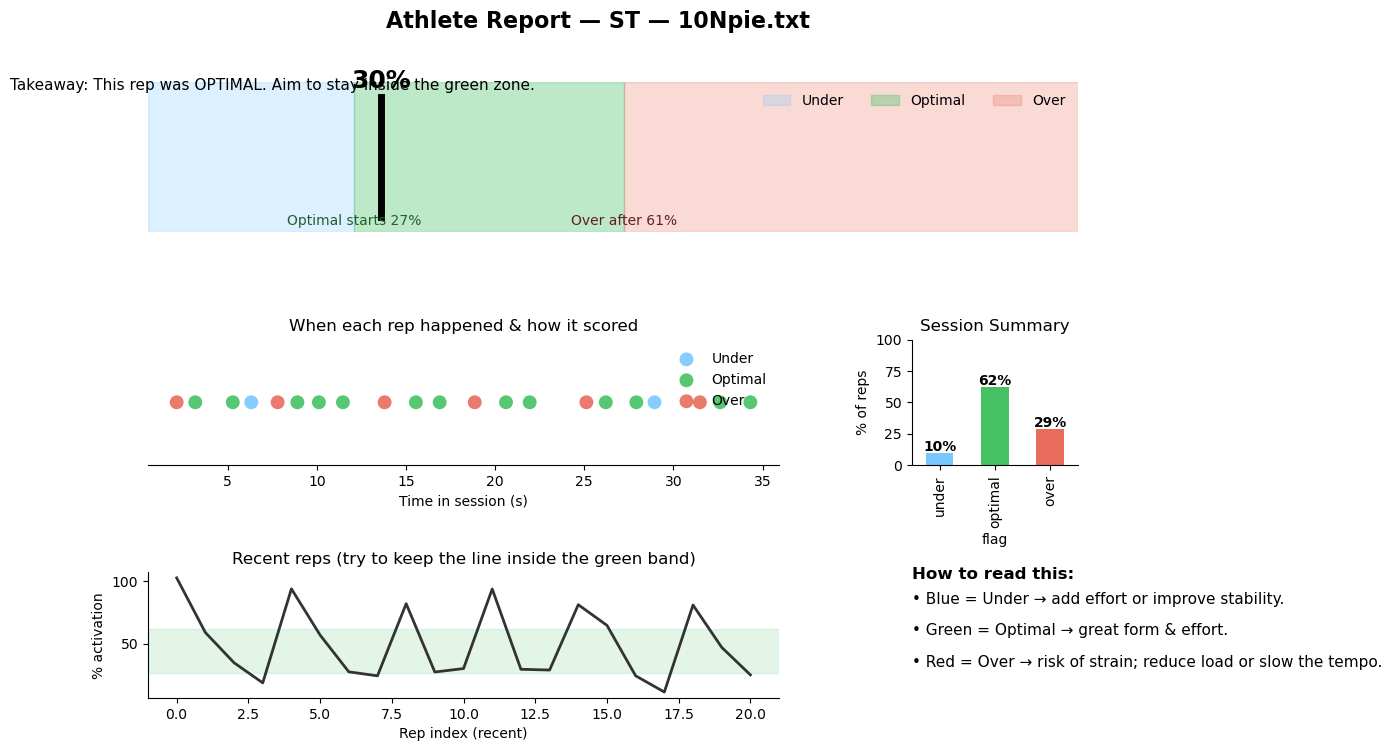

In [9]:
# ==================== Athlete Reports per Muscle (loads from outputs/) ====================
# Generates one dashboard per muscle: VM, RF, BF, ST
# Inputs (from disk):
#   - outputs/per_rep_predictions.csv         (required -> at least for VM)
#   - outputs/rep_metrics_v2.csv              (optional -> gives truth means per muscle)
# Output files:
#   - outputs/athlete_report_<MUSCLE>.png     (and optional PDF)

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ---------- settings ----------
OUTPUTS_DIR   = "outputs"
PRED_CSV      = os.path.join(OUTPUTS_DIR, "per_rep_predictions.csv")
METRICS_CSV   = os.path.join(OUTPUTS_DIR, "rep_metrics_v2.csv")   # optional but helps for non-VM muscles
MUSCLES       = ["VM", "RF", "BF", "ST"]
SESSION_FIELD = "file"           # group reports by recording file (use "sid" for athlete-centric)
RANDOM_SEED   = 7
SAVE_PDF      = False            # set True to also export PDFs

# ---------- load data ----------
if not os.path.exists(PRED_CSV):
    raise FileNotFoundError(
        f"Missing {PRED_CSV}. Run your modeling notebook first so it writes per_rep_predictions.csv."
    )
pred_df = pd.read_csv(PRED_CSV)
metrics_df = pd.read_csv(METRICS_CSV) if os.path.exists(METRICS_CSV) else None

# ---------- helpers ----------
C = {"under":"#79C7FF", "optimal":"#45C163", "over":"#E86C5B"}
rng = np.random.default_rng(RANDOM_SEED)

def learn_band(muscle, metrics_df=None, values_for_fallback=None, qlo=0.30, qhi=0.70, margin=0.10):
    """Learn optimal band from truth metrics; else from predicted values; else default."""
    if metrics_df is not None:
        col = f"{muscle}_rep_mean"
        if col in metrics_df.columns and metrics_df[col].notna().any():
            vals = metrics_df[col].dropna()
            lo, hi = vals.quantile(qlo), vals.quantile(qhi)
            span = hi - lo
            return (max(0, lo - margin*span), min(1000, hi + margin*span))
    if values_for_fallback is not None and len(values_for_fallback) > 0:
        vals = pd.Series(values_for_fallback).dropna()
        if len(vals) > 5:
            lo, hi = vals.quantile(qlo), vals.quantile(qhi)
            span = hi - lo
            return (max(0, lo - margin*span), min(1000, hi + margin*span))
    return (40, 60)

def add_flags(series, band, tol=5):
    lo, hi = band
    def _f(v):
        if not np.isfinite(v): return np.nan
        if v < lo - tol: return "under"
        if v > hi + tol: return "over"
        return "optimal"
    return series.apply(_f)

def pick_session(df, session_field=SESSION_FIELD):
    counts = df[session_field].value_counts()
    if counts.empty: return None, None
    key = counts.idxmax()
    s = df[df[session_field] == key].copy()
    if s.empty: return None, None
    return key, s

def draw_report(muscle, sess_df, band, save_basepath):
    """Draw gauge + timeline + bar + sparkline for one muscle/session."""
    lo, hi = band
    title = f"Athlete Report — {muscle} — {sess_df[SESSION_FIELD].iloc[0]}"
    # figure grid
    fig = plt.figure(figsize=(12, 8))
    gs  = fig.add_gridspec(nrows=3, ncols=3, height_ratios=[1.2, 1, 1], width_ratios=[2,1,1], hspace=0.8, wspace=0.6)
    fig.suptitle(title, fontsize=16, weight="bold", y=0.97)

    # 1) Gauge (top row full width)
    ax_g = fig.add_subplot(gs[0, :])
    row = sess_df.iloc[len(sess_df)//2]
    value = float(row["value"])
    ax_g.set_xlim(0, max(120, hi+20)); ax_g.set_ylim(0, 1)
    ax_g.axvspan(0, lo, color=C["under"],   alpha=0.25, label="Under")
    ax_g.axvspan(lo, hi, color=C["optimal"], alpha=0.35, label="Optimal")
    ax_g.axvspan(hi, max(120, hi+20), color=C["over"], alpha=0.25, label="Over")
    ax_g.plot([value, value], [0.1, 0.9], color="black", lw=5)
    ax_g.text(value, 0.93, f"{value:.0f}%", ha="center", va="bottom", fontsize=18, weight="bold")
    ax_g.text(lo, 0.05, f"Optimal starts {lo:.0f}%", ha="center", fontsize=10, color="#206030")
    ax_g.text(hi, 0.05, f"Over after {hi:.0f}%",   ha="center", fontsize=10, color="#602020")
    ax_g.axis("off")
    ax_g.legend(loc="upper right", ncols=3, frameon=False)
    cap_flag = row.get("flag", "optimal")
    fig.text(0.01, 0.87, f"Takeaway: This rep was {cap_flag.upper()}. Aim to stay inside the green zone.", fontsize=11)

    # 2) Session Summary (bar) — right column
    ax_bar = fig.add_subplot(gs[1, 2])
    summary = sess_df["flag"].value_counts(normalize=True).reindex(["under","optimal","over"]).fillna(0)*100
    summary.plot(kind="bar", color=[C.get(k,"#888") for k in summary.index], ax=ax_bar)
    ax_bar.set_ylim(0, 100)
    ax_bar.set_ylabel("% of reps")
    ax_bar.set_title("Session Summary")
    for i, v in enumerate(summary):
        ax_bar.text(i, v+2, f"{v:.0f}%", ha="center", weight="bold")
    ax_bar.spines[['top','right']].set_visible(False)

    # 3) Timeline (left two panels)
    ax_time = fig.add_subplot(gs[1, :2])
    x = sess_df["t_s"].values
    y = np.zeros_like(x)
    for flg in ["under","optimal","over"]:
        m = (sess_df["flag"].values == flg)
        if m.any():
            ax_time.scatter(x[m], y[m], s=100, color=C[flg], label=flg.capitalize(), alpha=0.9, edgecolor="none")
    ax_time.set_yticks([])
    ax_time.set_xlabel("Time in session (s)")
    ax_time.set_title("When each rep happened & how it scored")
    ax_time.legend(loc="upper right", frameon=False)
    ax_time.spines[['top','right','left']].set_visible(False)

    # 4) Guidance box (bottom right)
    ax_note = fig.add_subplot(gs[2, 2]); ax_note.axis("off")
    tips = [
        "Blue = Under → add effort or improve stability.",
        "Green = Optimal → great form & effort.",
        "Red = Over → risk of strain; reduce load or slow the tempo.",
    ]
    ax_note.text(0, 0.95, "How to read this:", fontsize=12, weight="bold")
    for i, t_ in enumerate(tips):
        ax_note.text(0, 0.75 - i*0.25, f"• {t_}", fontsize=11)

    # 5) Sparkline (bottom left wide)
    ax_spark = fig.add_subplot(gs[2, :2])
    last = sess_df.tail(min(25, len(sess_df)))
    ax_spark.plot(np.arange(len(last)), last["value"].values, lw=2, color="#333")
    ax_spark.axhspan(lo, hi, color=C["optimal"], alpha=0.15, zorder=0)
    ax_spark.set_title("Recent reps (try to keep the line inside the green band)")
    ax_spark.set_ylabel("% activation"); ax_spark.set_xlabel("Rep index (recent)")
    ax_spark.spines[['top','right']].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    os.makedirs(OUTPUTS_DIR, exist_ok=True)
    png_path = f"{save_basepath}.png"
    plt.savefig(png_path, dpi=160)
    if SAVE_PDF:
        pdf_path = f"{save_basepath}.pdf"
        plt.savefig(pdf_path)
        print(f"Saved: {png_path} and {pdf_path}")
    else:
        print(f"Saved: {png_path}")
    plt.show()

# ---------- build reports for each muscle ----------
for M in MUSCLES:
    # 1) choose source for 'value'
    # preference: prediction column (y_pred_<M>) if present -> else ground-truth mean from metrics -> else skip
    value_col_pred = f"y_pred_{M}"
    df = None

    if value_col_pred in pred_df.columns and pred_df[value_col_pred].notna().any():
        df = pred_df.rename(columns={value_col_pred:"value"})[["file","sid","t_s","t_e","value"]].copy()
    elif M == "VM" and "y_pred" in pred_df.columns and pred_df["y_pred"].notna().any():
        # your pipeline predicts VM into 'y_pred'
        df = pred_df.rename(columns={"y_pred":"value"})[["file","sid","t_s","t_e","value"]].copy()
    elif metrics_df is not None and f"{M}_rep_mean" in metrics_df.columns:
        df = metrics_df.rename(columns={f"{M}_rep_mean":"value"})[["file","sid","t_s","t_e","value"]].copy()
    else:
        print(f" Skipping {M}: no predictions or metrics found.")
        continue

    df = df.dropna(subset=["value"]).copy()
    if df.empty:
        print(f" Skipping {M}: no valid values.")
        continue

    # 2) band + flags
    fallback_vals = df["value"].values
    band = learn_band(M, metrics_df=metrics_df, values_for_fallback=fallback_vals)
    df["flag"] = add_flags(df["value"], band)

    # 3) pick a session and draw
    session_key, sess_df = pick_session(df, SESSION_FIELD)
    if sess_df is None:
        print(f" Skipping {M}: could not pick a session.")
        continue

    save_base = os.path.join(OUTPUTS_DIR, f"athlete_report_{M}")
    draw_report(M, sess_df, band, save_base)


In [10]:
# ================= BOOTSTRAP: bring back preprocess_file + parsable =================
# Drop this in a new cell and run it once per fresh kernel.

import os, re, glob, numpy as np, pandas as pd
from io import StringIO
from scipy.signal import butter, filtfilt, iirnotch

# ---- constants ----
FS = 1000                 # sampling rate (Hz)
BP_LOW, BP_HIGH = 20, 450 # EMG band-pass (Hz)
ENV_LP = 6                # envelope low-pass (Hz)
POWERLINE = 50            # powerline notch base (Hz)
NOTCH_Q = 30              # notch filter Q
ROBUST_Q = 95             # robust normalization percentile

# ---- robust numeric parser for weird .txt formats ----
_num_re = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')
def _parse_tokens(line: str):
    # convert decimal commas to dots, keep only numeric tokens
    line = re.sub(r'(?<=\d),(?=\d)', '.', line)
    return _num_re.findall(line)

def read_emg_txt(path: str) -> pd.DataFrame:
    with open(path, 'r', errors='ignore') as f:
        lines = f.readlines()
    # find first numeric line with at least 5 numbers (RF, BF, VM, ST, FX)
    start = None
    for i, ln in enumerate(lines):
        if len(_parse_tokens(ln)) >= 5:
            start = i; break
    if start is None:
        raise ValueError(f"No numeric data in {path}")
    rows = []
    for ln in lines[start:]:
        toks = _parse_tokens(ln)
        if len(toks) >= 5:
            rows.append(' '.join(toks[:5]))
    arr = np.loadtxt(StringIO('\n'.join(rows)))
    if arr.ndim == 1: arr = arr.reshape(-1, 5)
    return pd.DataFrame(arr, columns=['RF','BF','VM','ST','FX'])

# ---- safe filtfilt helper (short signals) ----
def _safe_filtfilt(b, a, x):
    x = np.asarray(x, float)
    pad = 3*(max(len(a), len(b))-1)
    if x.size <= pad+1:
        return filtfilt(b, a, x, method="gust")
    return filtfilt(b, a, x)

# ---- filters + envelope ----
def notch(sig, fs=FS, f0=50, q=NOTCH_Q):
    b,a = iirnotch(w0=f0/(fs/2), Q=q)
    return _safe_filtfilt(b,a,sig)

def bandpass(sig, fs=FS, low=BP_LOW, high=BP_HIGH, order=4):
    b,a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return _safe_filtfilt(b,a,sig)

def lowpass(sig, fs=FS, cutoff=ENV_LP, order=4):
    b,a = butter(order, cutoff/(fs/2), btype='low')
    return _safe_filtfilt(b,a,sig)

def emg_envelope(raw, fs=FS):
    x = np.asarray(raw, float)
    # notch 50/100/150 Hz
    for f0 in [POWERLINE, 2*POWERLINE, 3*POWERLINE]:
        x = notch(x, fs, f0=f0)
    x = bandpass(x, fs)
    x = np.abs(x)
    x = lowpass(x, fs)
    return x

def to_percent_activation(env, q=ROBUST_Q):
    ref = np.percentile(env, q)
    return (env / (ref + 1e-9)) * 100.0

def preprocess_file(path: str):
    """
    Returns:
      df_raw: DataFrame with raw channels ['RF','BF','VM','ST','FX']
      pct_df: DataFrame with %activation per muscle + FX (unchanged scale)
    """
    df = read_emg_txt(path)
    env = {ch: emg_envelope(df[ch].values, FS) for ch in ['RF','BF','VM','ST']}
    pct = {ch: to_percent_activation(env[ch]) for ch in env}
    pct_df = pd.DataFrame(pct)
    pct_df['FX'] = df['FX'].values
    return df, pct_df

# ---- locate your N_TXT folder and build 'parsable' ----
# EDIT this path if needed:
DATA_DIR = "SEMG_DB1 2/N_TXT"   # <-- set to your N_TXT folder

def list_txt_recursive(dd): 
    return sorted(glob.glob(os.path.join(dd, "**", "*.txt"), recursive=True))

def _try_len(path):
    try:
        return len(read_emg_txt(path))
    except Exception:
        return 0

all_txt = list_txt_recursive(DATA_DIR)
parsable = [(p, _try_len(p)) for p in all_txt if _try_len(p) > 0]

if not parsable:
    raise SystemExit("No valid trial files found. Check DATA_DIR and that it points to the N_TXT folder with recordings.")

# show a quick summary
parsable.sort(key=lambda x: x[1], reverse=True)
print(f"Found {len(parsable)} parsable recordings. Top few by length:")
for p,n in parsable[:8]:
    print(" -", os.path.basename(p), n)


Found 33 parsable recordings. Top few by length:
 - 10Npie.txt 36900
 - 10Nsen.txt 29220
 - 8Nsen.txt 24160
 - 9Npie.txt 22860
 - 7Nsen.txt 22460
 - 9Nsen.txt 21140
 - 6Nsen.txt 20500
 - 8Npie.txt 18340


In [11]:
# ================== NEXT STEP RUNNER: Dataset → LOSO → Final Model → Fatigue ==================
import os, re, numpy as np, pandas as pd
from scipy.signal import welch
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# ---- config you can tweak ----
MUSCLES   = ["VM","RF","BF","ST"]     # predict all four
PRED_CH   = ["VM","RF","BF","ST"]     # use all four as features
WIN_MS    = 200                       # 200 ms windows (RT-friendly)
HOP_MS    = 50                        # 50 ms hop
RANDOM_SEED = 7

# ---------- small helpers (feature engineering) ----------
def feats_time(a):
    a = np.asarray(a, float)
    return {"mean": float(np.nanmean(a)),
            "rms":  float(np.sqrt(np.nanmean(a**2))),
            "var":  float(np.nanvar(a)),
            "wl":   float(np.nansum(np.abs(np.diff(a))))}

def feats_freq(a, fs=FS):
    a = np.asarray(a, float)
    if np.nanstd(a) < 1e-9:
        return {"mf": 0.0, "sent": 0.0}
    f, pxx = welch(a, fs=fs, nperseg=min(512, len(a)))
    pxx = np.maximum(pxx, 1e-12)
    cs = np.cumsum(pxx); half = cs[-1] / 2.0
    mf = float(np.interp(half, cs, f))
    P = pxx / pxx.sum(); sent = float(-(P*np.log(P)).sum()/np.log(len(P)))
    return {"mf": mf, "sent": sent}

def sliding_windows(n, win, hop):
    for s in range(0, n - win + 1, hop):
        yield s, s + win

def subject_id(fname):
    m = re.search(r'^(\d+)', fname)
    return m.group(1) if m else fname

# ---------- A) Build multi-muscle dataset ----------
def build_multi_dataset(win_ms=WIN_MS, hop_ms=HOP_MS):
    win = int(FS * win_ms / 1000)
    hop = int(FS * hop_ms / 1000)
    rows, Y, groups, meta = [], [], [], []
    for path, _ in parsable:
        base = os.path.basename(path)
        sid  = subject_id(base)
        _, pct = preprocess_file(path)  # <- your robust pipeline
        n = len(pct)
        for s, e in sliding_windows(n, win, hop):
            feat = {"file": base, "sid": sid, "s": s, "e": e, "t_mid": (s+e)/(2*FS)}
            ok = True
            for ch in PRED_CH:
                w = pct[ch].values[s:e]
                if np.nanstd(w) < 1e-9:
                    ok = False; break
                feat.update({f"{ch}_{k}": v for k,v in feats_time(w).items()})
                feat.update({f"{ch}_{k}": v for k,v in feats_freq(w).items()})
                feat[f"{ch}_iEMG"] = float(np.trapz(np.abs(w)))
            if not ok: continue
            y = [float(np.nanmean(pct[m].values[s:e])) for m in MUSCLES]
            rows.append(feat); Y.append(y); groups.append(sid); meta.append((base, sid, s, e))
    X = pd.DataFrame(rows)
    Y = np.asarray(Y, float)
    groups = np.asarray(groups)
    return X, Y, groups, meta

print(" Building dataset (this may take a minute)…")
X_all, Y_all, groups_all, meta_all = build_multi_dataset()
print(" Dataset:", X_all.shape, "| Targets:", Y_all.shape, "| Subjects:", np.unique(groups_all).size)

# ---------- B) LOSO evaluation ----------
feat_cols = [c for c in X_all.columns if c not in ["file","sid","s","e"]]  # keep t_mid
param_grid = [
    {"n_estimators": 600, "max_depth": None, "min_samples_leaf": 2, "max_features": "sqrt"},
    {"n_estimators": 800, "max_depth": None, "min_samples_leaf": 2, "max_features": "sqrt"},
    {"n_estimators": 600, "max_depth": 24,   "min_samples_leaf": 2, "max_features": "sqrt"},
]

def eval_loso(cfg):
    gkf = GroupKFold(n_splits=min(max(3, np.unique(groups_all).size), 8))
    maes = {m:[] for m in MUSCLES}; r2s = {m:[] for m in MUSCLES}
    for tr, te in gkf.split(X_all, Y_all, groups_all):
        rf = RandomForestRegressor(random_state=42, n_jobs=-1, **cfg)
        rf.fit(X_all.iloc[tr][feat_cols], Y_all[tr])
        yhat = rf.predict(X_all.iloc[te][feat_cols])
        for i, m in enumerate(MUSCLES):
            maes[m].append(mean_absolute_error(Y_all[te, i], yhat[:, i]))
            r2s[m].append(r2_score(Y_all[te, i], yhat[:, i]))
    out = {m: {"MAE": float(np.mean(maes[m])), "R2": float(np.mean(r2s[m]))} for m in MUSCLES}
    avg_r2 = float(np.mean([out[m]["R2"] for m in MUSCLES]))
    return out, avg_r2

best_cfg, best_avg_r2, best_scores = None, -1e9, None
for cfg in param_grid:
    scores, avg_r2 = eval_loso(cfg)
    print(f"CFG {cfg} → avg R²={avg_r2:.3f} |", {m:(round(scores[m]['MAE'],2), round(scores[m]['R2'],3)) for m in MUSCLES})
    if avg_r2 > best_avg_r2:
        best_cfg, best_avg_r2, best_scores = cfg, avg_r2, scores

print("\n Best config:", best_cfg, "| avg R²:", round(best_avg_r2,3))
print("Per-muscle (MAE, R²):", {m:(round(best_scores[m]['MAE'],2), round(best_scores[m]['R2'],3)) for m in MUSCLES})

# ---------- C) Train final model on all data + save + fatigue summary ----------
print("\n Training final model and saving artifacts…")
rf_multi = RandomForestRegressor(random_state=42, n_jobs=-1, **best_cfg).fit(X_all[feat_cols], Y_all)
os.makedirs("models", exist_ok=True)
joblib.dump({"model": rf_multi, "feat_cols": feat_cols, "muscles": MUSCLES}, "models/multi_muscle_rf.joblib")
print(" Saved model → models/multi_muscle_rf.joblib")

# predictions across dataset
df_pred = X_all[["file","sid","s","e","t_mid"]].copy()
yhat = rf_multi.predict(X_all[feat_cols])
for i, m in enumerate(MUSCLES):
    df_pred[f"yhat_{m}"] = yhat[:, i]

# simple per-session fatigue indicators (trend slopes, mean, p10/p90)
rows = []
for (f, sid), grp in df_pred.groupby(["file","sid"]):
    out = {"file": f, "sid": sid}
    for m in MUSCLES:
        arr = grp[f"yhat_{m}"].values
        if len(arr) >= 5:
            x = np.arange(len(arr)); slope = np.polyfit(x, arr, 1)[0]
        else:
            slope = np.nan
        out[f"{m}_trend_slope"] = float(slope)              # negative → potential fatigue
        out[f"{m}_mean"] = float(np.nanmean(arr))
        out[f"{m}_p90"]  = float(np.nanpercentile(arr, 90))
        out[f"{m}_p10"]  = float(np.nanpercentile(arr, 10))
    rows.append(out)

fatigue_df = pd.DataFrame(rows)
os.makedirs("outputs", exist_ok=True)
fatigue_df.to_csv("outputs/fatigue_session_summary.csv", index=False)
df_pred.head(2000).to_csv("outputs/multi_muscle_window_predictions.csv", index=False)
print("Saved: outputs/fatigue_session_summary.csv and outputs/multi_muscle_window_predictions.csv")

# quick, readable summary for your report
print("\n=== LOSO Summary (report-ready) ===")
for m in MUSCLES:
    mae = best_scores[m]["MAE"]; r2 = best_scores[m]["R2"]
    print(f"{m}: MAE={mae:.2f} %activation | R²={r2:.3f}")


 Building dataset (this may take a minute)…
 Dataset: (9377, 33) | Targets: (9377, 4) | Subjects: 11
CFG {'n_estimators': 600, 'max_depth': None, 'min_samples_leaf': 2, 'max_features': 'sqrt'} → avg R²=0.948 | {'VM': (2.81, 0.959), 'RF': (2.75, 0.967), 'BF': (2.84, 0.949), 'ST': (3.05, 0.915)}
CFG {'n_estimators': 800, 'max_depth': None, 'min_samples_leaf': 2, 'max_features': 'sqrt'} → avg R²=0.948 | {'VM': (2.8, 0.959), 'RF': (2.75, 0.967), 'BF': (2.83, 0.949), 'ST': (3.06, 0.915)}
CFG {'n_estimators': 600, 'max_depth': 24, 'min_samples_leaf': 2, 'max_features': 'sqrt'} → avg R²=0.948 | {'VM': (2.81, 0.959), 'RF': (2.75, 0.967), 'BF': (2.84, 0.949), 'ST': (3.05, 0.915)}

 Best config: {'n_estimators': 600, 'max_depth': 24, 'min_samples_leaf': 2, 'max_features': 'sqrt'} | avg R²: 0.948
Per-muscle (MAE, R²): {'VM': (2.81, 0.959), 'RF': (2.75, 0.967), 'BF': (2.84, 0.949), 'ST': (3.05, 0.915)}

 Training final model and saving artifacts…
 Saved model → models/multi_muscle_rf.joblib
Saved:

/var/folders/pc/gb2h3yqd1114ct9bz8zdd6040000gn/T/ipykernel_77073/1792388676.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.96])


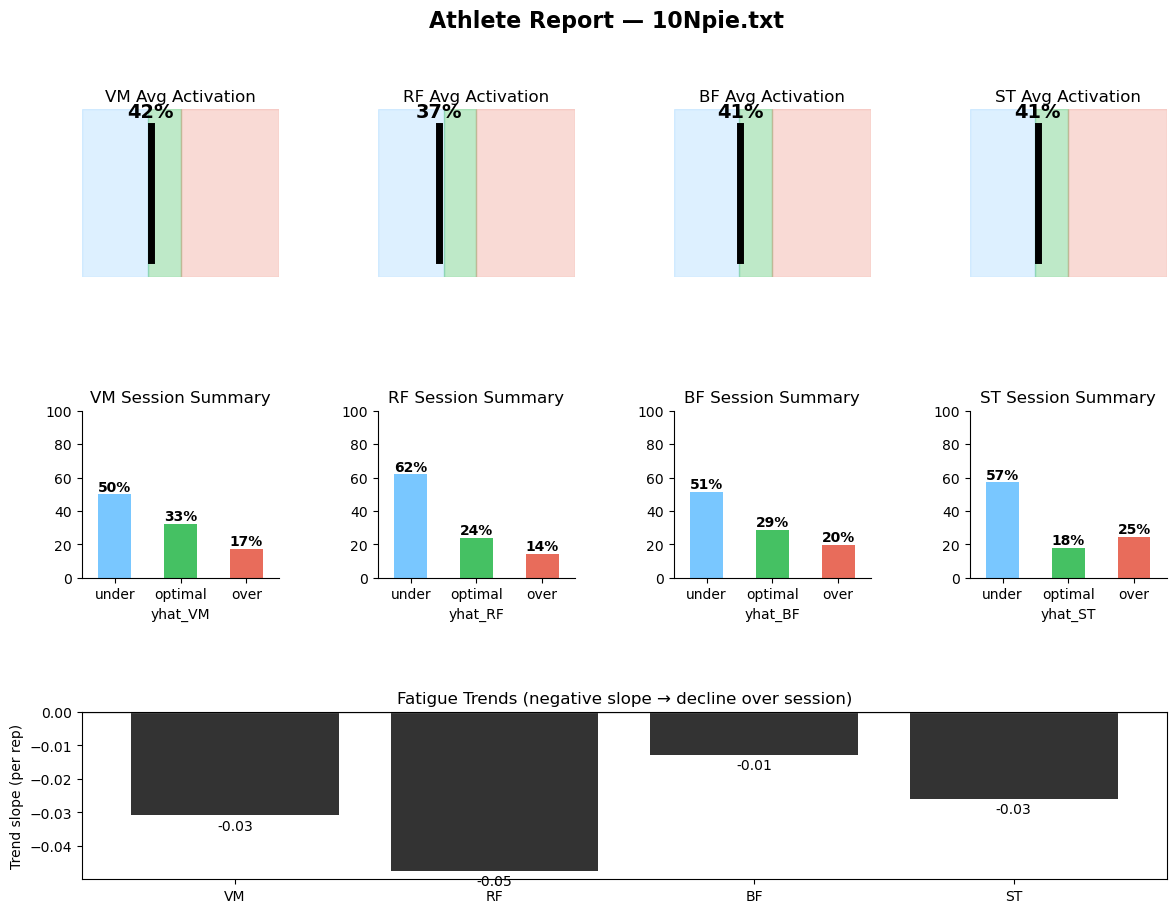

In [12]:
# ============= Multi-Muscle Athlete Report Dashboard ====================
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os

# Load predictions + fatigue summaries
pred_df = pd.read_csv("outputs/multi_muscle_window_predictions.csv")
fatigue_df = pd.read_csv("outputs/fatigue_session_summary.csv")

MUSCLES = ["VM","RF","BF","ST"]
C = {"under":"#79C7FF", "optimal":"#45C163", "over":"#E86C5B"}
VM_BAND = (40, 60)   # fallback; can learn bands per muscle if needed

# --- Pick one session (file with most reps) ---
session_key = pred_df["file"].value_counts().idxmax()
sess_df = pred_df[pred_df["file"]==session_key].copy()

# --- Helper to classify flags ---
def add_flags(series, band, tol=5):
    lo, hi = band
    def _f(v):
        if v < lo - tol: return "under"
        if v > hi + tol: return "over"
        return "optimal"
    return series.apply(_f)

# --- figure layout ---
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(3, 4, hspace=0.8, wspace=0.5)

# 1) Gauges for each muscle
for j, m in enumerate(MUSCLES):
    ax = fig.add_subplot(gs[0, j])
    val = sess_df[f"yhat_{m}"].mean()
    lo, hi = VM_BAND  # can set per-muscle if available
    ax.set_xlim(0, max(120, hi+20)); ax.set_ylim(0, 1)
    ax.axvspan(0, lo, color=C["under"],   alpha=0.25)
    ax.axvspan(lo, hi, color=C["optimal"], alpha=0.35)
    ax.axvspan(hi, max(120, hi+20), color=C["over"], alpha=0.25)
    ax.plot([val, val],[0.1,0.9], color="black", lw=5)
    ax.text(val, 0.93, f"{val:.0f}%", ha="center", va="bottom", fontsize=14, weight="bold")
    ax.axis("off")
    ax.set_title(f"{m} Avg Activation", fontsize=12)

# 2) Session summary bars
for j, m in enumerate(MUSCLES):
    ax = fig.add_subplot(gs[1, j])
    flags = add_flags(sess_df[f"yhat_{m}"], VM_BAND)
    summary = flags.value_counts(normalize=True).reindex(["under","optimal","over"]).fillna(0)*100
    summary.plot(kind="bar", color=[C.get(k,"#888") for k in summary.index], ax=ax)
    ax.set_ylim(0, 100); ax.set_xticklabels(summary.index, rotation=0)
    ax.set_title(f"{m} Session Summary")
    for i,v in enumerate(summary):
        ax.text(i, v+2, f"{v:.0f}%", ha="center", weight="bold")
    ax.spines[['top','right']].set_visible(False)

# 3) Fatigue trend lines (from fatigue_df)
ax_f = fig.add_subplot(gs[2, :])
session_fatigue = fatigue_df[fatigue_df["file"]==session_key].iloc[0]
slopes = [session_fatigue[f"{m}_trend_slope"] for m in MUSCLES]
ax_f.bar(MUSCLES, slopes, color=["#333"]*4)
ax_f.axhline(0, color="gray", lw=1)
ax_f.set_ylabel("Trend slope (per rep)")
ax_f.set_title("Fatigue Trends (negative slope → decline over session)")
for i,v in enumerate(slopes):
    ax_f.text(i, v+(0.001 if v>=0 else -0.001), f"{v:.2f}", ha="center", va="bottom" if v>=0 else "top")

fig.suptitle(f"Athlete Report — {session_key}", fontsize=16, weight="bold", y=0.98)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [13]:
# ===================== Generate Multi-Muscle PDF Dashboards =====================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

PRED_CSV    = "outputs/multi_muscle_window_predictions.csv"
FATIGUE_CSV = "outputs/fatigue_session_summary.csv"
OUT_DIR     = "outputs"
ALL_PDF     = os.path.join(OUT_DIR, "reports_all_sessions.pdf")

MUSCLES = ["VM","RF","BF","ST"]
COLORS  = {"under":"#79C7FF", "optimal":"#45C163", "over":"#E86C5B"}

# ----------------- load data -----------------
pred_df = pd.read_csv(PRED_CSV)
fatigue_df = pd.read_csv(FATIGUE_CSV)

# Learn a simple band per muscle from predictions (30–70% quantiles with margin), fallback (40,60)
def learn_band(series, qlo=0.30, qhi=0.70, margin=0.10, fallback=(40,60)):
    s = pd.Series(series).dropna()
    if s.empty:
        return fallback
    lo, hi = s.quantile(qlo), s.quantile(qhi)
    span = hi - lo
    return (max(0, lo - margin*span), min(1000, hi + margin*span))

# compute per-muscle bands across whole dataset
BANDS = {}
for m in MUSCLES:
    vals = pred_df[f"yhat_{m}"] if f"yhat_{m}" in pred_df.columns else pd.Series([])
    BANDS[m] = learn_band(vals, fallback=(40,60))

def add_flags(series, band, tol=5):
    lo, hi = band
    def _f(v):
        if v < lo - tol: return "under"
        if v > hi + tol: return "over"
        return "optimal"
    return series.apply(_f)

os.makedirs(OUT_DIR, exist_ok=True)

# ----------------- figure builder -----------------
def build_dashboard(fig, sess_df, session_key, bands=BANDS):
    gs = fig.add_gridspec(3, 4, hspace=0.8, wspace=0.5)
    fig.suptitle(f"Athlete Report — {session_key}", fontsize=16, weight="bold", y=0.98)

    # 1) Gauges
    for j, m in enumerate(MUSCLES):
        ax = fig.add_subplot(gs[0, j])
        ycol = f"yhat_{m}"
        if ycol not in sess_df.columns or sess_df[ycol].dropna().empty:
            ax.axis("off"); ax.set_title(f"{m}: no data"); continue
        val = sess_df[ycol].mean()
        lo, hi = bands.get(m, (40,60))
        ax.set_xlim(0, max(120, hi+20)); ax.set_ylim(0, 1)
        ax.axvspan(0, lo, color=COLORS["under"],   alpha=0.25)
        ax.axvspan(lo, hi, color=COLORS["optimal"], alpha=0.35)
        ax.axvspan(hi, max(120, hi+20), color=COLORS["over"], alpha=0.25)
        ax.plot([val, val],[0.1,0.9], color="black", lw=5)
        ax.text(val, 0.93, f"{val:.0f}%", ha="center", va="bottom", fontsize=14, weight="bold")
        ax.axis("off")
        ax.set_title(f"{m} Avg Activation", fontsize=12)

    # 2) Session summaries
    for j, m in enumerate(MUSCLES):
        ax = fig.add_subplot(gs[1, j])
        ycol = f"yhat_{m}"
        if ycol not in sess_df.columns or sess_df[ycol].dropna().empty:
            ax.axis("off"); ax.set_title(f"{m}: no data"); continue
        flags = add_flags(sess_df[ycol], bands.get(m, (40,60)))
        summary = flags.value_counts(normalize=True).reindex(["under","optimal","over"]).fillna(0)*100
        summary.plot(kind="bar", color=[COLORS.get(k,"#888") for k in summary.index], ax=ax)
        ax.set_ylim(0, 100); ax.set_xticklabels(summary.index, rotation=0)
        ax.set_title(f"{m} Session Summary")
        for i,v in enumerate(summary):
            ax.text(i, v+2, f"{v:.0f}%", ha="center", weight="bold")
        ax.spines[['top','right']].set_visible(False)

    # 3) Fatigue bar (slopes)
    ax_f = fig.add_subplot(gs[2, :])
    row = fatigue_df[fatigue_df["file"] == session_key]
    if row.empty:
        ax_f.text(0.5, 0.5, "No fatigue summary for this session", ha="center"); ax_f.axis("off")
    else:
        row = row.iloc[0]
        slopes = [row.get(f"{m}_trend_slope", np.nan) for m in MUSCLES]
        ax_f.bar(MUSCLES, slopes, color=["#333"]*4)
        ax_f.axhline(0, color="gray", lw=1)
        ax_f.set_ylabel("Trend slope (per rep)")
        ax_f.set_title("Fatigue Trends (negative slope → decline over session)")
        for i,v in enumerate(slopes):
            if np.isfinite(v):
                ax_f.text(i, v+(0.001 if v>=0 else -0.001), f"{v:.2f}",
                          ha="center", va="bottom" if v>=0 else "top")
    return fig

# ----------------- generate PDFs -----------------
all_pp = PdfPages(ALL_PDF)
made = 0

for session_key, sess_df in pred_df.groupby("file"):
    # one-page figure
    fig = plt.figure(figsize=(14, 10))
    build_dashboard(fig, sess_df.copy(), session_key, bands=BANDS)

    # save per-session PDF
    out_pdf = os.path.join(OUT_DIR, f"report_{os.path.splitext(session_key)[0]}.pdf")
    fig.savefig(out_pdf)
    # also add to the multi-page PDF
    all_pp.savefig(fig)
    plt.close(fig)
    made += 1
    print(f"Saved: {out_pdf}")

all_pp.close()
print(f"\n Combined multi-page PDF saved: {ALL_PDF}")
print(f"Total session reports: {made}")


Saved: outputs/report_10Npie.pdf
Saved: outputs/report_10Nsen.pdf
Saved: outputs/report_8Nsen.pdf
Saved: outputs/report_9Npie.pdf

 Combined multi-page PDF saved: outputs/reports_all_sessions.pdf
Total session reports: 4


Saved → outputs/loso_per_subject.csv


,fold,subject,muscle,MAE,R2
0,1,10,VM,1.787833,0.991305
1,1,10,RF,2.161749,0.972250
2,1,10,BF,1.979116,0.992181
3,1,10,ST,2.594306,0.965242
4,2,8,VM,4.285329,0.915781


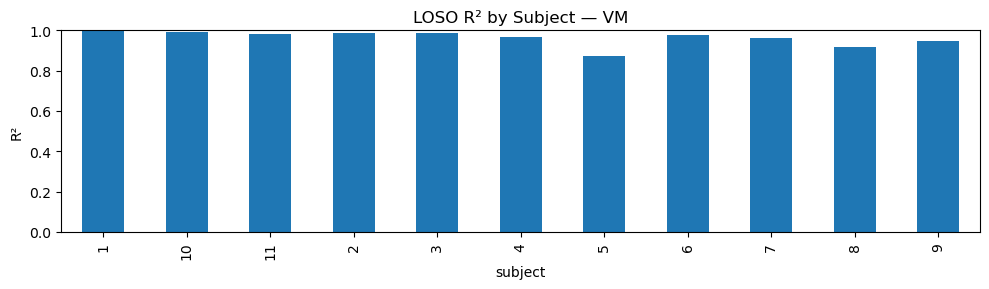

Saved → outputs/loso_r2_by_subject_VM.png


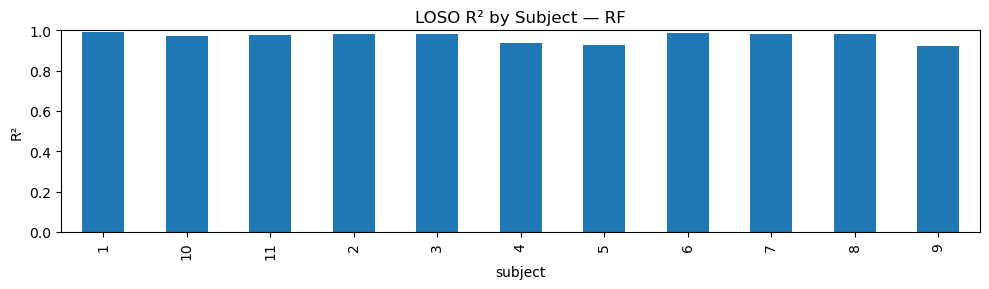

Saved → outputs/loso_r2_by_subject_RF.png


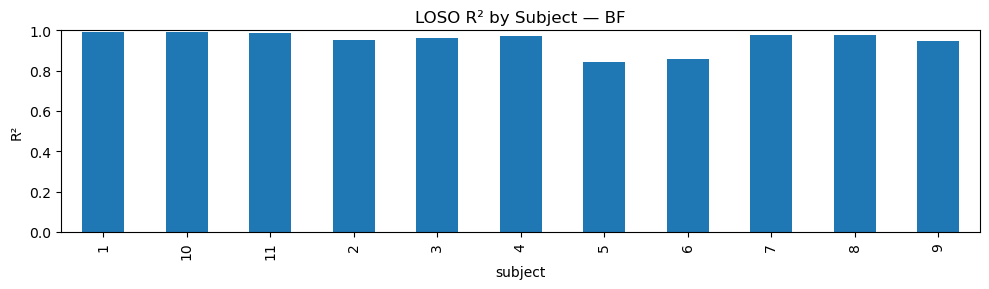

Saved → outputs/loso_r2_by_subject_BF.png


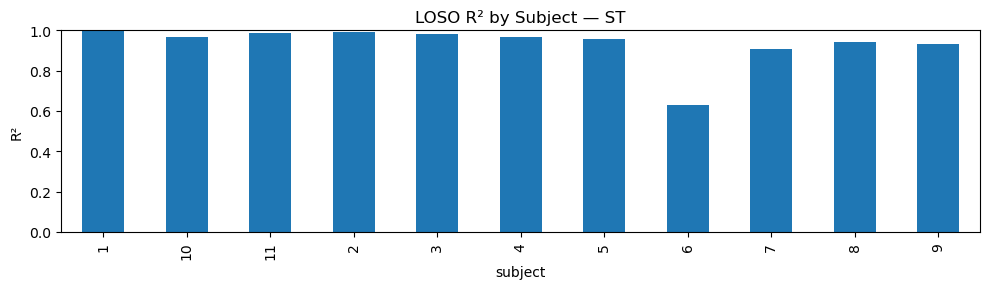

Saved → outputs/loso_r2_by_subject_ST.png


,muscle,MAE_mean,MAE_std,R2_mean,R2_std
0,BF,2.796055,1.118554,0.951795,0.052098
1,RF,2.591091,1.541019,0.967780,0.025253
2,ST,2.860613,1.107567,0.933136,0.103815
3,VM,2.631485,1.096915,0.962390,0.037366


Saved → outputs/loso_summary_by_muscle.csv


In [14]:
# ===== 1) LOSO per-subject metrics export + plots =====
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, r2_score

# sanity checks
assert 'X_all' in globals() and 'Y_all' in globals() and 'groups_all' in globals(), "Run dataset build cell first."
assert 'feat_cols' in globals() and 'MUSCLES' in globals(), "Run prev cells to define features and muscle list."

os.makedirs("outputs", exist_ok=True)

gkf = GroupKFold(n_splits=min(max(3, np.unique(groups_all).size), 8))
rows = []

cfg = globals().get('best_cfg', {"n_estimators": 600, "max_depth": 24, "min_samples_leaf": 2, "max_features": "sqrt"})
for fold, (tr, te) in enumerate(gkf.split(X_all, Y_all, groups_all), 1):
    subj_test = np.unique(groups_all[te]).tolist()
    rf = RandomForestRegressor(random_state=42, n_jobs=-1, **cfg)
    rf.fit(X_all.iloc[tr][feat_cols], Y_all[tr])
    yhat = rf.predict(X_all.iloc[te][feat_cols])
    # per-subject within this fold
    for sid in subj_test:
        msk = (groups_all[te] == sid)
        if not np.any(msk): continue
        for i, m in enumerate(MUSCLES):
            mae = mean_absolute_error(Y_all[te][msk, i], yhat[msk, i])
            r2  = r2_score(Y_all[te][msk, i], yhat[msk, i])
            rows.append({"fold": fold, "subject": sid, "muscle": m, "MAE": mae, "R2": r2})

per_subj = pd.DataFrame(rows)
per_subj.to_csv("outputs/loso_per_subject.csv", index=False)
print("Saved → outputs/loso_per_subject.csv")
display(per_subj.head())

# Quick bar plots (R² by subject for each muscle)
for m in MUSCLES:
    pivot = per_subj[per_subj["muscle"]==m].groupby("subject")["R2"].mean().sort_index()
    plt.figure(figsize=(10,3))
    pivot.plot(kind="bar")
    plt.title(f"LOSO R² by Subject — {m}")
    plt.ylabel("R²"); plt.ylim(0,1)
    plt.tight_layout()
    out = f"outputs/loso_r2_by_subject_{m}.png"
    plt.savefig(out, dpi=140); plt.show()
    print("Saved →", out)

# Overall table (mean ± std per muscle)
summary = per_subj.groupby("muscle").agg(MAE_mean=("MAE","mean"), MAE_std=("MAE","std"),
                                         R2_mean=("R2","mean"), R2_std=("R2","std")).reset_index()
display(summary)
summary.to_csv("outputs/loso_summary_by_muscle.csv", index=False)
print("Saved → outputs/loso_summary_by_muscle.csv")

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


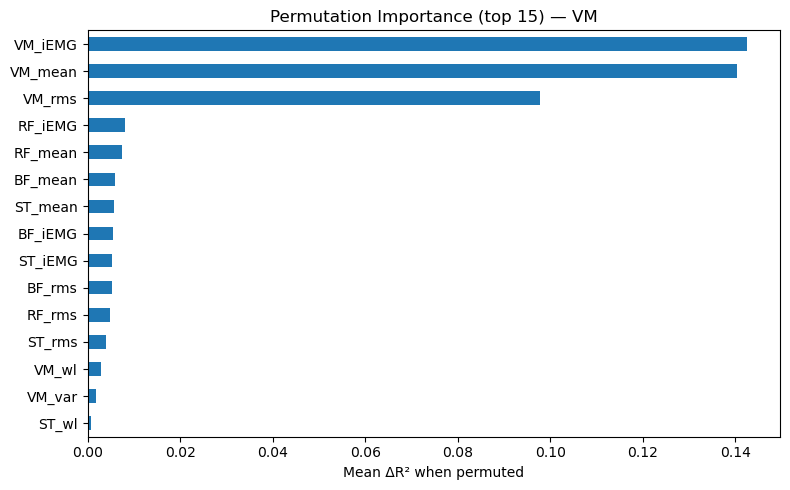

Saved → outputs/perm_importance_VM.png


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


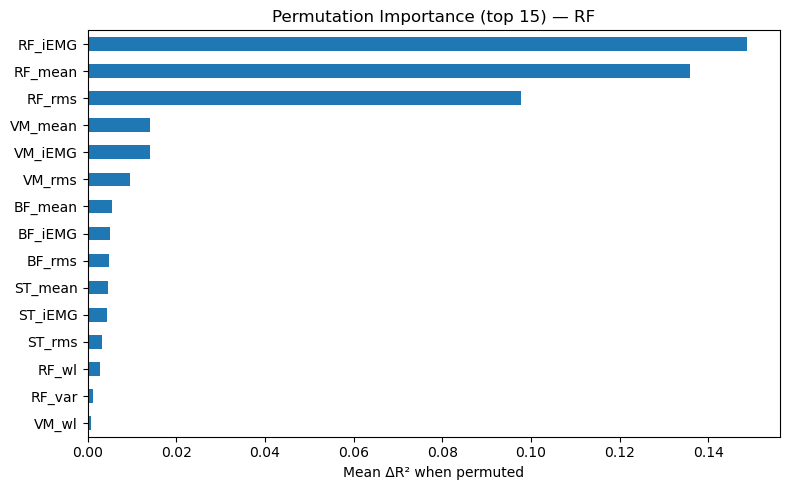

Saved → outputs/perm_importance_RF.png


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


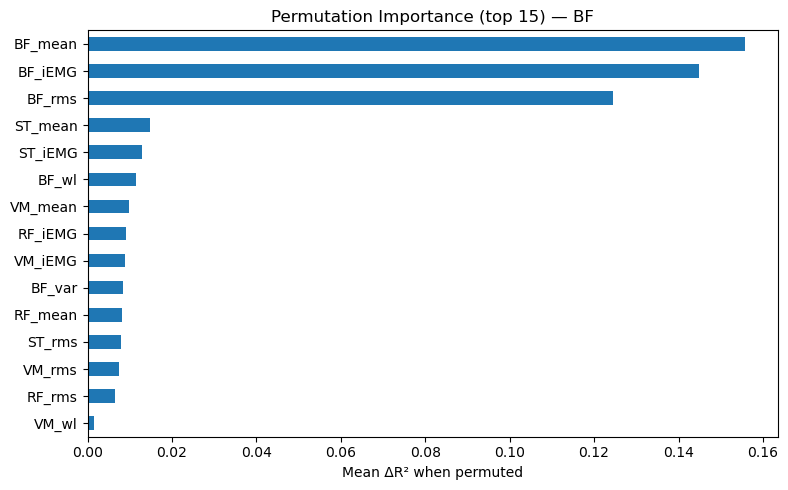

Saved → outputs/perm_importance_BF.png


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


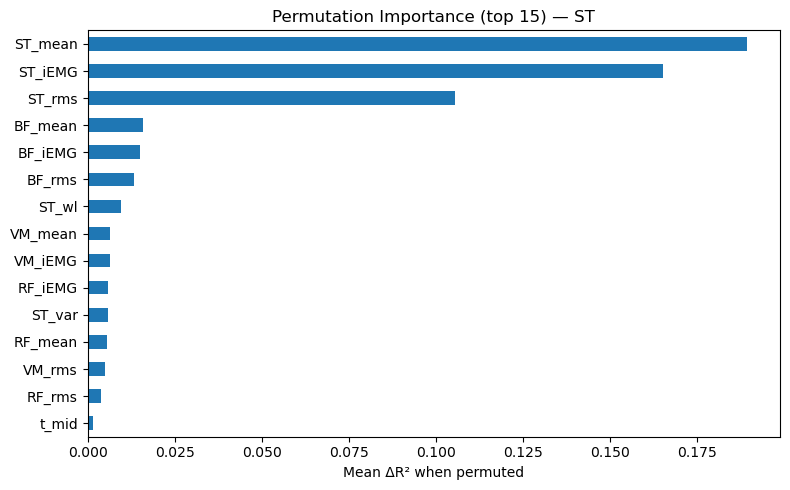

Saved → outputs/perm_importance_ST.png


,VM,RF,BF,ST
BF_iEMG,0.005516,0.005084,0.144808,0.015140
BF_mean,0.005865,0.005424,0.155801,0.016056
BF_rms,0.005202,0.004791,0.124521,0.013231
BF_var,NaN,NaN,0.008360,NaN
BF_wl,0.000648,0.000476,0.011457,0.000652
RF_iEMG,0.008008,0.148722,0.009144,0.005992
RF_mean,0.007337,0.135775,0.008168,0.005475
RF_rms,0.004743,0.097708,0.006522,0.003801
RF_var,0.000565,0.001324,0.000820,0.000884
RF_wl,0.000726,0.002883,0.000953,0.000932


Saved → outputs/perm_importance_top20_all_muscles.csv


In [15]:
# ===== Fixed permutation importance for multi-output model =====
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
import os

assert 'rf_multi' in globals(), "Train final model cell first to create rf_multi."
assert 'feat_cols' in globals() and 'MUSCLES' in globals()
assert 'X_all' in globals() and 'Y_all' in globals()

# Subsample for speed (optional)
N = min(3000, len(X_all))
rng = np.random.default_rng(7)
idx = rng.choice(len(X_all), size=N, replace=False)
Xsub = X_all.iloc[idx][feat_cols]
Ysub = Y_all[idx]

def make_scorer_i(i):
    def scorer(estimator, X, y_true):
        y_pred = estimator.predict(X)[:, i]   # only the i-th output
        return r2_score(y_true, y_pred)
    return scorer

imps = {}
os.makedirs("outputs", exist_ok=True)

for i, m in enumerate(MUSCLES):
    scorer_i = make_scorer_i(i)
    r = permutation_importance(
        rf_multi, Xsub, Ysub[:, i],
        scoring=scorer_i, n_repeats=10, random_state=7, n_jobs=-1
    )
    imp = pd.Series(r.importances_mean, index=feat_cols).sort_values(ascending=False)
    imps[m] = imp

    # save + plot top-15
    imp.to_csv(f"outputs/perm_importance_{m}.csv", header=["importance"])
    top = imp.head(15)
    plt.figure(figsize=(8,5))
    top.iloc[::-1].plot(kind="barh")
    plt.title(f"Permutation Importance (top 15) — {m}")
    plt.xlabel("Mean ΔR² when permuted")
    plt.tight_layout()
    out = f"outputs/perm_importance_{m}.png"
    plt.savefig(out, dpi=140); plt.show()
    print("Saved →", out)

# Combined table of top features across muscles
top_union = pd.DataFrame({m: imps[m].head(20) for m in MUSCLES})
display(top_union.head(25))
top_union.to_csv("outputs/perm_importance_top20_all_muscles.csv")
print("Saved → outputs/perm_importance_top20_all_muscles.csv")

In [16]:
# ===== 3) Ablations: without t_mid, and without frequency features =====
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np, pandas as pd

def loso_score(feature_list, cfg):
    gkf = GroupKFold(n_splits=min(max(3, np.unique(groups_all).size), 8))
    r2s = {m:[] for m in MUSCLES}; maes = {m:[] for m in MUSCLES}
    for tr, te in gkf.split(X_all, Y_all, groups_all):
        rf = RandomForestRegressor(random_state=42, n_jobs=-1, **cfg)
        rf.fit(X_all.iloc[tr][feature_list], Y_all[tr])
        yhat = rf.predict(X_all.iloc[te][feature_list])
        for i,m in enumerate(MUSCLES):
            r2s[m].append(r2_score(Y_all[te, i], yhat[:, i]))
            maes[m].append(mean_absolute_error(Y_all[te, i], yhat[:, i]))
    return {m: (float(np.mean(maes[m])), float(np.mean(r2s[m]))) for m in MUSCLES}

cfg = globals().get('best_cfg', {"n_estimators": 600, "max_depth": 24, "min_samples_leaf": 2, "max_features": "sqrt"})

# Baseline (current features)
base_scores = loso_score(feat_cols, cfg)

# A) No t_mid
feat_no_tmid = [c for c in feat_cols if c != "t_mid"]
no_tmid_scores = loso_score(feat_no_tmid, cfg)

# B) No frequency features (drop *_mf and *_sent)
feat_no_freq = [c for c in feat_cols if not (c.endswith("_mf") or c.endswith("_sent"))]
no_freq_scores = loso_score(feat_no_freq, cfg)

# Summarize
def as_df(label, scores):
    rows = [{"setup": label, "muscle": m, "MAE": mae, "R2": r2} for m,(mae,r2) in scores.items()]
    return pd.DataFrame(rows)

comp = pd.concat([
    as_df("baseline", base_scores),
    as_df("no_tmid", no_tmid_scores),
    as_df("no_freq", no_freq_scores),
], ignore_index=True)

display(comp.pivot(index="muscle", columns="setup", values="R2"))
comp.to_csv("outputs/ablation_results.csv", index=False)
print("Saved → outputs/ablation_results.csv")

# Quick print deltas vs baseline
print("\nΔR² vs baseline:")
for m in MUSCLES:
    b = base_scores[m][1]
    print(f"{m}: no_tmid {no_tmid_scores[m][1]-b:+.003f} | no_freq {no_freq_scores[m][1]-b:+.003f}")

setup,baseline,no_freq,no_tmid
muscle,,,
BF,0.948698,0.951946,0.949559
RF,0.967411,0.969478,0.967655
ST,0.915478,0.918462,0.915942
VM,0.958938,0.960601,0.960009


Saved → outputs/ablation_results.csv

ΔR² vs baseline:
VM: no_tmid +0.001 | no_freq +0.002
RF: no_tmid +0.000 | no_freq +0.002
BF: no_tmid +0.001 | no_freq +0.003
ST: no_tmid +0.000 | no_freq +0.003


In [17]:
# Retrain a leaner multi-output RF (no *_mf, *_sent, and no t_mid)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np, pandas as pd, joblib, os

feat_lean = [c for c in feat_cols if (c != "t_mid" and not c.endswith("_mf") and not c.endswith("_sent"))]

# confirm LOSO with lean features
gkf = GroupKFold(n_splits=min(max(3, np.unique(groups_all).size), 8))
maes = {m:[] for m in MUSCLES}; r2s = {m:[] for m in MUSCLES}
cfg = best_cfg

for tr, te in gkf.split(X_all, Y_all, groups_all):
    rf = RandomForestRegressor(random_state=42, n_jobs=-1, **cfg)
    rf.fit(X_all.iloc[tr][feat_lean], Y_all[tr])
    yhat = rf.predict(X_all.iloc[te][feat_lean])
    for i,m in enumerate(MUSCLES):
        maes[m].append(mean_absolute_error(Y_all[te, i], yhat[:, i]))
        r2s[m].append(r2_score(Y_all[te, i], yhat[:, i]))

print("Lean LOSO (MAE, R²):", {m:(np.mean(maes[m]), np.mean(r2s[m])) for m in MUSCLES})

# train on all data and save
rf_lean = RandomForestRegressor(random_state=42, n_jobs=-1, **cfg).fit(X_all[feat_lean], Y_all)
os.makedirs("models", exist_ok=True)
joblib.dump({"model": rf_lean, "feat_cols": feat_lean, "muscles": MUSCLES, "note": "lean_nofreq_notmid"},
            "models/multi_muscle_rf_lean.joblib")
print("Saved → models/multi_muscle_rf_lean.joblib")

Lean LOSO (MAE, R²): {'VM': (2.631254954573575, 0.9614370240092209), 'RF': (2.564937840382658, 0.970291705194732), 'BF': (2.639893293390508, 0.9531809406494812), 'ST': (2.8544768350677225, 0.919601442107642)}
Saved → models/multi_muscle_rf_lean.joblib


In [18]:
# ================== Re-run predictions & regenerate PDFs (LEAN model) ==================
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import joblib

assert 'X_all' in globals() and 'Y_all' in globals() and 'groups_all' in globals()
assert 'MUSCLES' in globals()

# ---- load lean model ----
OBJ = joblib.load("models/multi_muscle_rf_lean.joblib")
rf_lean   = OBJ["model"]
feat_lean = OBJ["feat_cols"]
muscles   = OBJ["muscles"]

# ---- fresh predictions across the whole dataset ----
df_pred = X_all[["file","sid","s","e"]].copy()
df_pred["t_mid"] = (df_pred["s"]+df_pred["e"])/(2*FS)  # keep for plotting, not a model input
yhat = rf_lean.predict(X_all[feat_lean])
for i, m in enumerate(muscles):
    df_pred[f"yhat_{m}"] = yhat[:, i]

# ---- session fatigue summary (same logic, using new preds) ----
rows = []
for (f, sid), grp in df_pred.groupby(["file","sid"]):
    out = {"file": f, "sid": sid}
    for m in muscles:
        arr = grp[f"yhat_{m}"].values
        if len(arr) >= 5:
            x = np.arange(len(arr))
            slope = np.polyfit(x, arr, 1)[0]
        else:
            slope = np.nan
        out[f"{m}_trend_slope"] = float(slope)
        out[f"{m}_mean"] = float(np.nanmean(arr))
        out[f"{m}_p90"]  = float(np.nanpercentile(arr, 90))
        out[f"{m}_p10"]  = float(np.nanpercentile(arr, 10))
    rows.append(out)

fatigue_df = pd.DataFrame(rows)
os.makedirs("outputs", exist_ok=True)
PRED_CSV    = "outputs/multi_muscle_window_predictions_LEAN.csv"
FATIGUE_CSV = "outputs/fatigue_session_summary_LEAN.csv"
df_pred.to_csv(PRED_CSV, index=False)
fatigue_df.to_csv(FATIGUE_CSV, index=False)
print("Saved:", PRED_CSV, "and", FATIGUE_CSV)

# ---- simple per-muscle bands learned from predictions (quantile-based) ----
def learn_band(series, qlo=0.30, qhi=0.70, margin=0.10, fallback=(40,60)):
    s = pd.Series(series).dropna()
    if s.empty: return fallback
    lo, hi = s.quantile(qlo), s.quantile(qhi)
    span = hi - lo
    return (max(0, lo - margin*span), min(1000, hi + margin*span))

BANDS = {m: learn_band(df_pred[f"yhat_{m}"]) for m in muscles}

# ---- helpers for flags & dashboard ----
COLORS  = {"under":"#79C7FF", "optimal":"#45C163", "over":"#E86C5B"}
def add_flags(series, band, tol=5):
    lo, hi = band
    def _f(v):
        if v < lo - tol: return "under"
        if v > hi + tol: return "over"
        return "optimal"
    return series.apply(_f)

def build_dashboard(fig, sess_df, session_key, bands=BANDS):
    gs = fig.add_gridspec(3, 4, hspace=0.8, wspace=0.5)
    fig.suptitle(f"Athlete Report — {session_key} (LEAN)", fontsize=16, weight="bold", y=0.98)

    # 1) Gauges
    for j, m in enumerate(muscles):
        ax = fig.add_subplot(gs[0, j])
        ycol = f"yhat_{m}"
        if ycol not in sess_df.columns or sess_df[ycol].dropna().empty:
            ax.axis("off"); ax.set_title(f"{m}: no data"); continue
        val = sess_df[ycol].mean()
        lo, hi = bands.get(m, (40,60))
        ax.set_xlim(0, max(120, hi+20)); ax.set_ylim(0, 1)
        ax.axvspan(0, lo, color=COLORS["under"],   alpha=0.25)
        ax.axvspan(lo, hi, color=COLORS["optimal"], alpha=0.35)
        ax.axvspan(hi, max(120, hi+20), color=COLORS["over"], alpha=0.25)
        ax.plot([val, val],[0.1,0.9], color="black", lw=5)
        ax.text(val, 0.93, f"{val:.0f}%", ha="center", va="bottom", fontsize=14, weight="bold")
        ax.axis("off")
        ax.set_title(f"{m} Avg Activation", fontsize=12)

    # 2) Session summaries
    for j, m in enumerate(muscles):
        ax = fig.add_subplot(gs[1, j])
        ycol = f"yhat_{m}"
        flags = add_flags(sess_df[ycol], bands.get(m, (40,60)))
        summary = flags.value_counts(normalize=True).reindex(["under","optimal","over"]).fillna(0)*100
        summary.plot(kind="bar", color=[COLORS.get(k,"#888") for k in summary.index], ax=ax)
        ax.set_ylim(0, 100); ax.set_xticklabels(summary.index, rotation=0)
        ax.set_title(f"{m} Session Summary")
        for i,v in enumerate(summary):
            ax.text(i, v+2, f"{v:.0f}%", ha="center", weight="bold")
        ax.spines[['top','right']].set_visible(False)

    # 3) Fatigue bar (slopes)
    ax_f = fig.add_subplot(gs[2, :])
    row = fatigue_df[fatigue_df["file"] == session_key]
    if row.empty:
        ax_f.text(0.5, 0.5, "No fatigue summary for this session", ha="center"); ax_f.axis("off")
    else:
        row = row.iloc[0]
        slopes = [row.get(f"{m}_trend_slope", np.nan) for m in muscles]
        ax_f.bar(muscles, slopes, color=["#333"]*4)
        ax_f.axhline(0, color="gray", lw=1)
        ax_f.set_ylabel("Trend slope (per rep)")
        ax_f.set_title("Fatigue Trends (negative slope → decline over session)")
        for i,v in enumerate(slopes):
            if np.isfinite(v):
                ax_f.text(i, v+(0.001 if v>=0 else -0.001), f"{v:.2f}",
                          ha="center", va="bottom" if v>=0 else "top")
    return fig

# ---- generate PDFs ----
OUT_DIR = "outputs"
ALL_PDF = os.path.join(OUT_DIR, "reports_all_sessions_LEAN.pdf")
pp_all = PdfPages(ALL_PDF)
count = 0

for session_key, sess_df in df_pred.groupby("file"):
    fig = plt.figure(figsize=(14,10))
    build_dashboard(fig, sess_df.copy(), session_key, bands=BANDS)
    out_pdf = os.path.join(OUT_DIR, f"report_{os.path.splitext(session_key)[0]}_LEAN.pdf")
    fig.savefig(out_pdf)
    pp_all.savefig(fig)
    plt.close(fig)
    count += 1
    print("Saved:", out_pdf)

pp_all.close()
print(f"\n Combined multi-page PDF saved: {ALL_PDF}  |  Total sessions: {count}")

Saved: outputs/multi_muscle_window_predictions_LEAN.csv and outputs/fatigue_session_summary_LEAN.csv
Saved: outputs/report_10Nmar_LEAN.pdf
Saved: outputs/report_10Npie_LEAN.pdf
Saved: outputs/report_10Nsen_LEAN.pdf
Saved: outputs/report_11Nmar_LEAN.pdf
Saved: outputs/report_11Npie_LEAN.pdf
Saved: outputs/report_11Nsen_LEAN.pdf
Saved: outputs/report_1Nmar_LEAN.pdf
Saved: outputs/report_1Npie_LEAN.pdf
Saved: outputs/report_1Nsen_LEAN.pdf
Saved: outputs/report_2Nmar_LEAN.pdf
Saved: outputs/report_2Npie_LEAN.pdf
Saved: outputs/report_2Nsen_LEAN.pdf
Saved: outputs/report_3Nmar_LEAN.pdf
Saved: outputs/report_3Npie_LEAN.pdf
Saved: outputs/report_3Nsen_LEAN.pdf
Saved: outputs/report_4Nmar_LEAN.pdf
Saved: outputs/report_4Npie_LEAN.pdf
Saved: outputs/report_4Nsen_LEAN.pdf
Saved: outputs/report_5Nmar_LEAN.pdf
Saved: outputs/report_5Npie_LEAN.pdf
Saved: outputs/report_5Nsen_LEAN.pdf
Saved: outputs/report_6Nmar_LEAN.pdf
Saved: outputs/report_6Npie_LEAN.pdf
Saved: outputs/report_6Nsen_LEAN.pdf
Saved

In [19]:
# Install web server deps into the *current* kernel
%pip install fastapi uvicorn pydantic==2.9.2 --quiet

# sanity check
import pydantic
from fastapi import FastAPI
import uvicorn
print("FastAPI import OK | Pydantic:", pydantic.__version__)

Note: you may need to restart the kernel to use updated packages.
FastAPI import OK | Pydantic: 2.9.2


In [23]:
# serve_lean_api.py
from typing import Dict, List, Optional
from fastapi import FastAPI
from pydantic import BaseModel, Field
from fastapi.middleware.cors import CORSMiddleware
import joblib, numpy as np

# ---- Load model ----
OBJ = joblib.load("models/multi_muscle_rf_lean.joblib")
MODEL     = OBJ["model"]
FEAT_COLS = OBJ["feat_cols"]
MUSCLES   = OBJ["muscles"]
DEFAULT_BANDS = {m: (40, 60) for m in MUSCLES}

app = FastAPI(title="EMG Lean Predictor", version="1.0")

app.add_middleware(
    CORSMiddleware, allow_origins=["*"],
    allow_credentials=True, allow_methods=["*"], allow_headers=["*"]
)

class WindowPayload(BaseModel):
    fs: int = Field(1000, description="Sampling rate Hz")
    data: Dict[str, List[float]] = Field(..., description="{'VM':[...],'RF':[...],'BF':[...],'ST':[...]}")
    bands: Optional[Dict[str, List[float]]] = None

def feats_lean(a: np.ndarray):
    a = np.asarray(a, float)
    if a.size < 5 or not np.isfinite(a).any():
        return {"mean":0.0,"rms":0.0,"var":0.0,"wl":0.0,"iEMG":0.0}
    return {
        "mean": float(np.nanmean(a)),
        "rms":  float(np.sqrt(np.nanmean(a**2))),
        "var":  float(np.nanvar(a)),
        "wl":   float(np.nansum(np.abs(np.diff(a)))),
        "iEMG": float(np.trapz(np.abs(a))),
    }

def build_feature_row(payload: WindowPayload):
    feat = {}
    for m in MUSCLES:
        arr = np.asarray(payload.data.get(m, []), float)
        f = feats_lean(arr)
        for k, v in f.items():
            feat[f"{m}_{k}"] = v
    x = np.array([feat.get(c, 0.0) for c in FEAT_COLS]).reshape(1, -1)
    return x

def flag_val(v: float, band: tuple[float,float], tol: float = 5):
    lo, hi = band
    if v < lo - tol: return "under"
    if v > hi + tol: return "over"
    return "optimal"

@app.get("/health")
def health():
    return {"ok": True, "muscles": MUSCLES, "features": len(FEAT_COLS)}

@app.post("/predict_window")
def predict_window(payload: WindowPayload):
    x = build_feature_row(payload)
    yhat = MODEL.predict(x)[0]
    preds = {m: float(yhat[i]) for i, m in enumerate(MUSCLES)}

    bands = DEFAULT_BANDS.copy()
    if payload.bands:
        for m, b in payload.bands.items():
            if m in bands and isinstance(b, (list, tuple)) and len(b) == 2:
                bands[m] = (float(b[0]), float(b[1]))

    flags = {m: flag_val(preds[m], bands[m]) for m in MUSCLES}
    return {"pred": preds, "flags": flags, "bands_used": bands}

In [25]:
# Write a minimal FastAPI server file next to this notebook
api_code = r'''
from typing import Dict, List, Optional
from fastapi import FastAPI
from pydantic import BaseModel, Field
from fastapi.middleware.cors import CORSMiddleware
import joblib, numpy as np

# ---- Load model artifact ----
OBJ = joblib.load("models/multi_muscle_rf_lean.joblib")
MODEL     = OBJ["model"]
FEAT_COLS = OBJ["feat_cols"]
MUSCLES   = OBJ["muscles"]
DEFAULT_BANDS = {m: (40, 60) for m in MUSCLES}

app = FastAPI(title="EMG Lean Predictor", version="1.0")
app.add_middleware(CORSMiddleware, allow_origins=["*"], allow_credentials=True,
                   allow_methods=["*"], allow_headers=["*"])

class WindowPayload(BaseModel):
    fs: int = Field(1000, description="Sampling rate Hz")
    data: Dict[str, List[float]] = Field(..., description="{'VM':[...],'RF':[...],'BF':[...],'ST':[...]}")
    bands: Optional[Dict[str, List[float]]] = None

def feats_lean(a: np.ndarray):
    a = np.asarray(a, float)
    if a.size < 5 or not np.isfinite(a).any():
        return {"mean":0.0,"rms":0.0,"var":0.0,"wl":0.0,"iEMG":0.0}
    return {
        "mean": float(np.nanmean(a)),
        "rms":  float(np.sqrt(np.nanmean(a**2))),
        "var":  float(np.nanvar(a)),
        "wl":   float(np.nansum(np.abs(np.diff(a)))),
        "iEMG": float(np.trapz(np.abs(a))),
    }

def build_feature_row(payload: WindowPayload):
    feat = {}
    for m in MUSCLES:
        arr = np.asarray(payload.data.get(m, []), float)
        f = feats_lean(arr)
        for k, v in f.items():
            feat[f"{m}_{k}"] = v
    x = np.array([feat.get(c, 0.0) for c in FEAT_COLS]).reshape(1, -1)
    return x

def flag_val(v: float, band: tuple[float,float], tol: float = 5):
    lo, hi = band
    if v < lo - tol: return "under"
    if v > hi + tol: return "over"
    return "optimal"

@app.get("/health")
def health():
    return {"ok": True, "muscles": MUSCLES, "features": len(FEAT_COLS)}

@app.post("/predict_window")
def predict_window(payload: WindowPayload):
    x = build_feature_row(payload)
    yhat = MODEL.predict(x)[0]
    preds = {m: float(yhat[i]) for i, m in enumerate(MUSCLES)}

    bands = DEFAULT_BANDS.copy()
    if payload.bands:
        for m, b in payload.bands.items():
            if m in bands and isinstance(b, (list, tuple)) and len(b) == 2:
                bands[m] = (float(b[0]), float(b[1]))

    flags = {m: flag_val(preds[m], bands[m]) for m in MUSCLES}
    return {"pred": preds, "flags": flags, "bands_used": bands}
'''
with open("serve_lean_api.py", "w") as f:
    f.write(api_code)

import os; print("Wrote:", os.path.abspath("serve_lean_api.py"))

Wrote: /Users/chirugowda/Desktop/phythom_projects/serve_lean_api.py


In [26]:
%pip install fastapi uvicorn pydantic==2.9.2 --quiet

Note: you may need to restart the kernel to use updated packages.


In [27]:
# Quick validator
import importlib, sys, os, json, numpy as np
MODULE_NAME = "serve_lean_api"

if MODULE_NAME in sys.modules: del sys.modules[MODULE_NAME]
api = importlib.import_module(MODULE_NAME)
print("Imported:", api.app)

# Dummy request through FastAPI TestClient 
try:
    from fastapi.testclient import TestClient
    client = TestClient(api.app)
    print("Health:", client.get("/health").json())
    payload = {
        "fs": 1000,
        "data": {m: (40 + 5*np.random.randn(200)).tolist() for m in api.MUSCLES},
        "bands": {m: [40,60] for m in api.MUSCLES}
    }
    r = client.post("/predict_window", json=payload)
    print("Predict:", r.status_code, list(r.json().get("pred", {}).items())[:2])
except Exception as e:
    print("TestClient skipped:", e)

Imported: <fastapi.applications.FastAPI object at 0x38c95ef60>
Health: {'ok': True, 'muscles': ['VM', 'RF', 'BF', 'ST'], 'features': 20}
Predict: 200 [('VM', 41.14962070505592), ('RF', 37.827063063408154)]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
